In [33]:
import os 
import sys
from tqdm import tqdm
import pickle
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = '/home/lun/project-basileus/seq-gan/sgtlstm'
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
if 'sgtlstm' in sys.modules:
    importlib.reload(sys.modules['sgtlstm'])

from sgtlstm.utils import load_fixed_length_sequence_from_pickle, create_dataset
from sgtlstm.SeqGan import build_G, build_D
from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3
from sgtlstm.train import generate_one_sequence_by_rollout, train_discriminator, train_generator

## Load data 

In [3]:
valid_data_path = '/home/lun/project-basileus/seq-gan/data/fixed_length_with_init_token/valid_sequences.pickle'
invalid_data_path = '/home/lun/project-basileus/seq-gan/data/fixed_length_with_init_token/invalid_sequences.pickle'

valid_event_type_seqs, valid_timestamp_seqs = load_fixed_length_sequence_from_pickle(valid_data_path, to_timedelta=True, end_token=0)
invalid_event_type_seqs, invalid_timestamp_seqs = load_fixed_length_sequence_from_pickle(invalid_data_path, to_timedelta=True, end_token=0)

## Global Variables 

In [4]:
BATCH_SIZE = 128
T = 10 + 1
VOCAB = ['END/PADDING', 'INIT', 'start', 'click', 'install']
EVENT_VOCAB_DIM = len(VOCAB)
EMB_DIM = 5
HIDDEN_DIM = 64
K_MIST = 7

END_TOKEN = 0
MAX_TIME = 1024

## Load pretrained model

In [5]:
discriminator = build_D(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST
)
discriminator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

D_save_path = './gan_model_weights/pretrain_1000_disc/model.tf'
discriminator.load_weights(D_save_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


In [6]:
generator = build_G(
    T = T,
    event_vocab_dim = EVENT_VOCAB_DIM,
    emb_dim = EMB_DIM,
    hidden_dim= HIDDEN_DIM,
    k_mixt = K_MIST,
    return_sequence=False,
)
generator.build(input_shape=((BATCH_SIZE, T, 1), (BATCH_SIZE, T, 1)))

G_save_path = './gan_model_weights/pretrain_1000_gen_clip/model.tf'
generator.load_weights(G_save_path)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
sigma > 1 !!


# Train G and D for 2 epochs

In [7]:
train_et = valid_event_type_seqs
train_ts = valid_timestamp_seqs

train_labels = np.ones((valid_event_type_seqs.shape[0], 1))

train_features = (train_et, train_ts)
N_train = train_et.shape[0]

In [8]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=2,
                         buffer_size=N_train)

# gen_token_loss_history = []
# gen_gaussian_loss_history = []

# disc_token_loss_history = []
# disc_gaussian_loss_history = []

WEIGHT_GAUSSIAN_LOSS = 1e-2
_G_STEPS = 2
_D_STEPS = 1

In [14]:
_TOTAL_STEPS = 180

step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


4it [03:39, 54.82s/it]

Training Step: 5


5it [04:29, 53.46s/it]

Training Step: 6


6it [05:21, 53.01s/it]

Training Step: 7


7it [06:17, 53.97s/it]

Training Step: 8


8it [07:09, 53.32s/it]

Training Step: 9


9it [08:04, 53.65s/it]

Training Step: 10


10it [09:01, 54.80s/it]

Training Step: 11


11it [09:53, 54.03s/it]

Training Step: 12


12it [10:47, 54.08s/it]

Training Step: 13


13it [11:39, 53.19s/it]

Training Step: 14


14it [12:26, 51.32s/it]

Training Step: 15


15it [13:25, 53.86s/it]

Training Step: 16


16it [14:15, 52.62s/it]

Training Step: 17


17it [15:09, 53.07s/it]

Training Step: 18


18it [16:00, 52.25s/it]

Training Step: 19


19it [16:49, 51.56s/it]

Training Step: 20


20it [17:46, 52.93s/it]

Training Step: 21


21it [18:39, 53.01s/it]

Training Step: 22


22it [19:36, 54.23s/it]

Training Step: 23


23it [20:26, 53.04s/it]

Training Step: 24


24it [21:22, 53.93s/it]

Training Step: 25


25it [22:17, 54.32s/it]

Training Step: 26


26it [23:13, 54.69s/it]

Training Step: 27


27it [24:08, 54.95s/it]

Training Step: 28


28it [24:59, 53.58s/it]

Training Step: 29


29it [25:53, 53.73s/it]

Training Step: 30


30it [26:39, 51.49s/it]

Training Step: 31


31it [27:36, 52.96s/it]

Training Step: 32


32it [28:28, 52.74s/it]

Training Step: 33


33it [29:20, 52.50s/it]

Training Step: 34


34it [30:05, 50.46s/it]

Training Step: 35


35it [31:00, 51.69s/it]

Training Step: 36


36it [31:58, 53.46s/it]

Training Step: 37


37it [32:49, 52.73s/it]

Training Step: 38


38it [33:47, 54.40s/it]

Training Step: 39


39it [34:37, 53.18s/it]

Training Step: 40


40it [35:28, 52.51s/it]

Training Step: 41


41it [36:20, 52.32s/it]

Training Step: 42


42it [37:06, 50.48s/it]

Training Step: 43


43it [38:03, 52.35s/it]

Training Step: 44


44it [38:52, 51.20s/it]

Training Step: 45


45it [39:48, 52.73s/it]

Training Step: 46


46it [40:36, 51.41s/it]

Training Step: 47


47it [41:23, 50.14s/it]

Training Step: 48


48it [42:10, 49.00s/it]

Training Step: 49


49it [43:07, 51.63s/it]

Training Step: 50


50it [43:57, 51.13s/it]

Training Step: 51


51it [44:47, 50.70s/it]

Training Step: 52


52it [45:41, 51.67s/it]

Training Step: 53


53it [46:34, 52.11s/it]

Training Step: 54


54it [47:22, 50.93s/it]

Training Step: 55


55it [48:13, 50.73s/it]

Training Step: 56


56it [49:06, 51.67s/it]

Training Step: 57


57it [50:03, 53.25s/it]

Training Step: 58


58it [50:56, 52.98s/it]

Training Step: 59


59it [51:49, 53.17s/it]

Training Step: 60


60it [52:44, 53.62s/it]

Training Step: 61


61it [53:38, 53.68s/it]

Training Step: 62


62it [54:30, 53.15s/it]

Training Step: 63


63it [55:26, 54.00s/it]

Training Step: 64


64it [56:21, 54.32s/it]

Training Step: 65


65it [57:15, 54.21s/it]

Training Step: 66


66it [58:08, 53.94s/it]

Training Step: 67


67it [58:59, 53.18s/it]

Training Step: 68


68it [59:50, 52.28s/it]

Training Step: 69


69it [1:00:46, 53.41s/it]

Training Step: 70


70it [1:01:39, 53.48s/it]

Training Step: 71


71it [1:02:34, 53.78s/it]

Training Step: 72


72it [1:03:33, 55.25s/it]

Training Step: 73


73it [1:04:29, 55.60s/it]

Training Step: 74


74it [1:05:20, 54.09s/it]

Training Step: 75


75it [1:06:11, 53.39s/it]

Training Step: 76


76it [1:07:05, 53.43s/it]

Training Step: 77


77it [1:08:02, 54.48s/it]

Training Step: 78


78it [1:09:00, 55.62s/it]

Training Step: 79


79it [1:09:45, 52.40s/it]

Training Step: 80


80it [1:10:42, 53.93s/it]

Training Step: 81


81it [1:11:40, 54.95s/it]

Training Step: 82


82it [1:12:35, 54.92s/it]

Training Step: 83


83it [1:13:31, 55.44s/it]

Training Step: 84


84it [1:14:23, 54.31s/it]

Training Step: 85


85it [1:15:17, 54.24s/it]

Training Step: 86


86it [1:16:11, 54.05s/it]

Training Step: 87


87it [1:17:08, 55.01s/it]

Training Step: 88


88it [1:17:59, 53.74s/it]

Training Step: 89


89it [1:18:55, 54.48s/it]

Training Step: 90


90it [1:19:46, 53.61s/it]

Training Step: 91


91it [1:20:39, 53.28s/it]

Training Step: 92


92it [1:21:35, 54.18s/it]

Training Step: 93


93it [1:22:23, 52.21s/it]

Training Step: 94


94it [1:23:15, 52.30s/it]

Training Step: 95


95it [1:24:15, 54.49s/it]

Training Step: 96


96it [1:25:09, 54.48s/it]

Training Step: 97


97it [1:26:03, 54.25s/it]

Training Step: 98


98it [1:26:54, 53.13s/it]

Training Step: 99


99it [1:27:43, 52.04s/it]

Training Step: 100


100it [1:28:38, 52.99s/it]

Training Step: 101


101it [1:29:31, 52.80s/it]

Training Step: 102


102it [1:30:26, 53.65s/it]

Training Step: 103


103it [1:31:20, 53.78s/it]

Training Step: 104


104it [1:32:15, 53.93s/it]

Training Step: 105


105it [1:33:07, 53.47s/it]

Training Step: 106


106it [1:34:02, 53.95s/it]

Training Step: 107


107it [1:35:00, 55.20s/it]

Training Step: 108


108it [1:35:55, 54.93s/it]

Training Step: 109


109it [1:36:52, 55.75s/it]

Training Step: 110


110it [1:37:47, 55.56s/it]

Training Step: 111


111it [1:38:44, 55.80s/it]

Training Step: 112


112it [1:39:34, 54.19s/it]

Training Step: 113


113it [1:40:23, 52.64s/it]

Training Step: 114


114it [1:41:17, 53.09s/it]

Training Step: 115


115it [1:42:12, 53.52s/it]

Training Step: 116


116it [1:43:09, 54.56s/it]

Training Step: 117


117it [1:43:58, 53.01s/it]

Training Step: 118


118it [1:44:54, 53.78s/it]

Training Step: 119


119it [1:45:52, 55.17s/it]

Training Step: 120


120it [1:46:45, 54.56s/it]

Training Step: 121


121it [1:47:40, 54.70s/it]

Training Step: 122


122it [1:48:27, 52.36s/it]

Training Step: 123


123it [1:49:18, 51.81s/it]

Training Step: 124


124it [1:50:12, 52.67s/it]

Training Step: 125


125it [1:51:04, 52.41s/it]

Training Step: 126


126it [1:52:02, 53.88s/it]

Training Step: 127


127it [1:52:56, 54.15s/it]

Training Step: 128


128it [1:53:49, 53.57s/it]

Training Step: 129


129it [1:54:50, 55.91s/it]

Training Step: 130


130it [1:55:46, 55.97s/it]

Training Step: 131


131it [1:56:42, 56.01s/it]

Training Step: 132


132it [1:57:33, 54.53s/it]

Training Step: 133


133it [1:58:31, 55.65s/it]

Training Step: 134


134it [1:59:27, 55.54s/it]

Training Step: 135


135it [2:00:19, 54.61s/it]

Training Step: 136


136it [2:01:16, 55.30s/it]

Training Step: 137


137it [2:02:07, 54.06s/it]

Training Step: 138


138it [2:02:59, 53.41s/it]

Training Step: 139


139it [2:03:54, 53.83s/it]

Training Step: 140


140it [2:04:45, 53.47s/it]


## 2 epochs: Loss over training

Text(0.5, 0, 'training steps')

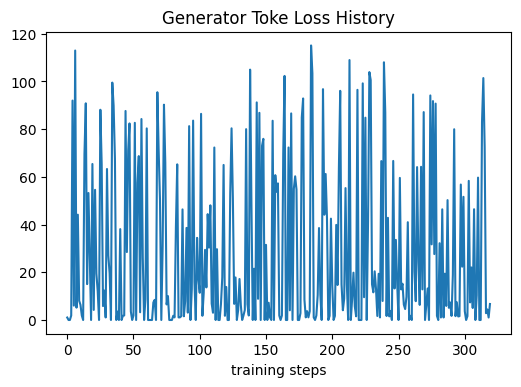

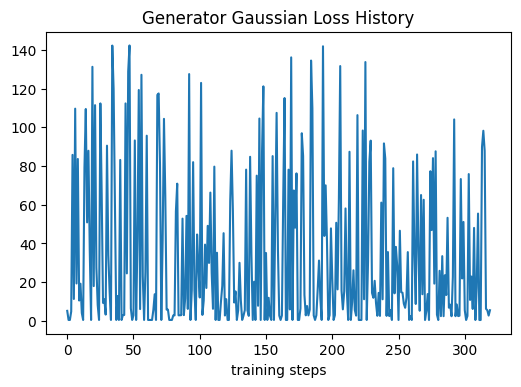

In [15]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

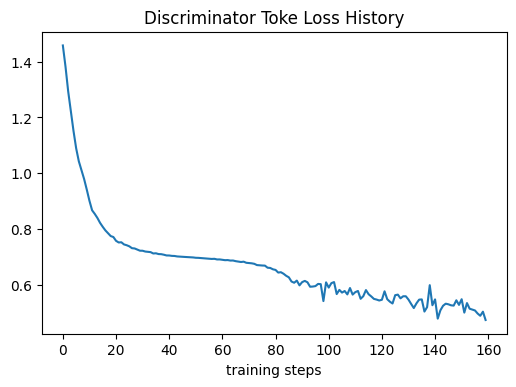

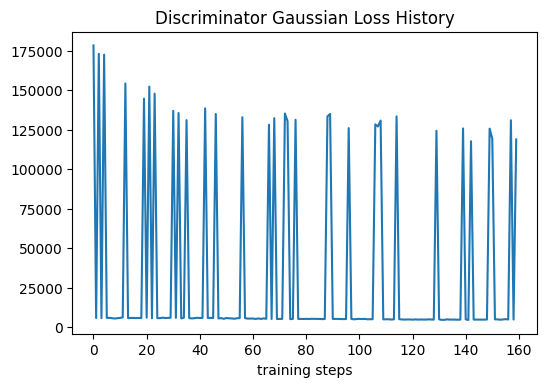

In [16]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

In [31]:
loss_save_dir = './experiment_results/after_2_epochs/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_gaussian_loss_history, f)

## 2 epochs: Save G and D models

In [28]:
G_save_dir = './experiment_results/after_2_epochs/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [29]:
D_save_dir = './experiment_results/after_2_epochs/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 2 epochs: Generate sequences 

In [17]:
# states_et, states_ts, episode_token_probs, gaussian_log = generate_one_seq(generator)
# states_et.squeeze()

def recover_timedelta_to_timestamp(time_seq):
    csum = []
    curr = 0
    
    for dt in time_seq:
        if dt != 0:
            curr += dt
            csum.append(curr)
        else:
            csum.append(0)
    
    return csum

# recover_timedelta_to_timestamp(time_seq)

In [25]:
N_gen = 1000 # 
generated_seqs = []

for i in tqdm(range(N_gen)):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout(generator,
                                                                                               T, EVENT_VOCAB_DIM,
                                                                                               verbose=False)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 100 == 0:
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

  0%|          | 2/1000 [00:00<02:04,  8.00it/s]

0
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


  5%|▌         | 52/1000 [00:15<04:15,  3.71it/s]

50
[(1.0, 0), (2.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 10%|█         | 103/1000 [00:27<04:36,  3.25it/s]

100
[(1.0, 0), (4.0, 1.0), (1.0, 2.0), (1.0, 5.285688928473894), (2.0, 7.873176572835315), (4.0, 9.82634548180074), (4.0, 11.373931705977418), (2.0, 14.00367627475012), (1.0, 15.691987561988867), (1.0, 18.500166408855822), (2.0, 19.631399317384325)]


 15%|█▌        | 152/1000 [00:44<03:48,  3.72it/s]

150
[(1.0, 0), (1.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 20%|██        | 202/1000 [00:59<02:50,  4.68it/s]

200
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 25%|██▌       | 251/1000 [01:17<06:14,  2.00it/s]

250
[(1.0, 0), (2.0, 1.0), (2.0, 2.01396991117275), (3.0, 3.421489909392551), (4.0, 4.421489909392551), (2.0, 5.450027713049039), (1.0, 6.450027713049039), (4.0, 7.450027713049039), (2.0, 9.422380779195336), (0.0, 0), (0.0, 0)]


 30%|███       | 301/1000 [01:33<03:59,  2.92it/s]

300
[(1.0, 0), (2.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 35%|███▌      | 351/1000 [01:47<02:39,  4.08it/s]

350
[(1.0, 0), (3.0, 1.6940152272747377), (1.0, 4.0660139947670615), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 40%|████      | 401/1000 [02:03<03:14,  3.08it/s]

400
[(1.0, 0), (4.0, 1.0), (3.0, 2.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 45%|████▌     | 451/1000 [02:19<02:56,  3.11it/s]

450
[(1.0, 0), (1.0, 1.0), (1.0, 2.0), (3.0, 3.174325331071856), (1.0, 6.2223218157433), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 50%|█████     | 501/1000 [02:33<02:56,  2.83it/s]

500
[(1.0, 0), (2.0, 1.0), (4.0, 2.0936266441416187), (2.0, 3.0936266441416187), (2.0, 4.093626644141619), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 55%|█████▌    | 550/1000 [02:48<02:58,  2.52it/s]

550
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 60%|██████    | 600/1000 [03:02<01:43,  3.88it/s]

600
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 65%|██████▌   | 651/1000 [03:17<01:34,  3.71it/s]

650
[(1.0, 0), (1.0, 1.0), (4.0, 2.7562399024825526), (1.0, 3.7562399024825526), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 70%|███████   | 701/1000 [03:31<01:08,  4.36it/s]

700
[(1.0, 0), (2.0, 1.0), (3.0, 2.9429669741621867), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 75%|███████▌  | 751/1000 [03:49<01:25,  2.92it/s]

750
[(1.0, 0), (2.0, 1.5147777002873495), (3.0, 3.5845847911238433), (2.0, 5.957076911333662), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 80%|████████  | 801/1000 [04:05<01:19,  2.49it/s]

800
[(1.0, 0), (3.0, 1.0), (3.0, 4.074089144343246), (4.0, 6.3569915679788895), (2.0, 8.2425745250336), (4.0, 10.529118283110662), (4.0, 12.606824387088384), (3.0, 15.83534271372449), (4.0, 17.209853826383224), (4.0, 18.209853826383224), (0.0, 0)]


 85%|████████▌ | 851/1000 [04:22<01:04,  2.33it/s]

850
[(1.0, 0), (2.0, 1.0), (1.0, 2.465825269258181), (4.0, 3.6105430468098554), (3.0, 5.692659099383561), (2.0, 6.692659099383561), (4.0, 7.692659099383561), (3.0, 9.6331578243228), (2.0, 10.6331578243228), (3.0, 11.895878204282013), (1.0, 14.1204108227567)]


 90%|█████████ | 901/1000 [04:39<00:29,  3.39it/s]

900
[(1.0, 0), (4.0, 1.6025402371445578), (4.0, 3.7705453680216863), (1.0, 6.4904663771085955), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 95%|█████████▌| 951/1000 [04:55<00:19,  2.57it/s]

950
[(1.0, 0), (3.0, 1.176695413813662), (1.0, 2.176695413813662), (1.0, 5.5687989712355), (3.0, 6.5687989712355), (1.0, 8.89203193226653), (3.0, 10.451263311282032), (2.0, 11.451263311282032), (3.0, 13.44480471604319), (2.0, 14.861060758454668), (0.0, 0)]


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]


In [35]:
generated_seqs_save_dir = './experiment_results/after_2_epochs/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

# Continue Training G and D for 4 more epochs, in total 6

In [42]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=4,
                         buffer_size=N_train)

WEIGHT_GAUSSIAN_LOSS = 1e-2
_G_STEPS = 2
_D_STEPS = 1
N_total = train_features[0].shape[0]

In [44]:
_TOTAL_STEPS = int(N_total / BATCH_SIZE * 4)

step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/lun/.conda/envs/tf2_py37/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 4133, in <genexpr>
    for ta, out in zip(output_ta_t, flat_new_output))  File "/home/lun/.conda/envs/tf2_py37/lib/python3.7/site-packages/tensorflow_core/python/util/tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/lun/.conda/envs/tf2_py37/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 4133, in <genexpr>
    for ta, ou

1it [01:00, 60.20s/it]

Training Step: 2


2it [01:52, 57.78s/it]

Training Step: 3


3it [02:41, 55.12s/it]

Training Step: 4


4it [03:32, 54.03s/it]

Training Step: 5


5it [04:25, 53.61s/it]

Training Step: 6


6it [05:16, 52.98s/it]

Training Step: 7


7it [06:09, 52.81s/it]

Training Step: 8


8it [07:02, 52.98s/it]

Training Step: 9


9it [07:56, 53.38s/it]

Training Step: 10


10it [08:47, 52.39s/it]

Training Step: 11


12it [10:28, 51.58s/it]

Training Step: 13


13it [11:22, 52.22s/it]

Training Step: 14


14it [12:14, 52.40s/it]

Training Step: 15


15it [13:01, 50.63s/it]

Training Step: 16


16it [13:56, 51.91s/it]

Training Step: 17


17it [14:46, 51.27s/it]

Training Step: 18


18it [15:43, 53.16s/it]

Training Step: 19


19it [16:39, 54.06s/it]

Training Step: 20


20it [17:33, 53.86s/it]

Training Step: 21


21it [18:21, 52.23s/it]

Training Step: 22


22it [19:08, 50.64s/it]

Training Step: 23


23it [20:03, 51.79s/it]

Training Step: 24


24it [20:59, 53.32s/it]

Training Step: 25


25it [21:54, 53.63s/it]

Training Step: 26


26it [22:40, 51.27s/it]

Training Step: 27


27it [23:29, 50.72s/it]

Training Step: 28


28it [24:24, 52.16s/it]

Training Step: 29


29it [25:17, 52.33s/it]

Training Step: 30


30it [26:09, 52.25s/it]

Training Step: 31


31it [27:03, 52.70s/it]

Training Step: 32


32it [27:57, 53.17s/it]

Training Step: 33


33it [28:49, 52.61s/it]

Training Step: 34


34it [29:43, 53.25s/it]

Training Step: 35


35it [30:31, 51.50s/it]

Training Step: 36


36it [31:19, 50.63s/it]

Training Step: 37


37it [32:12, 51.36s/it]

Training Step: 38


38it [33:08, 52.69s/it]

Training Step: 39


39it [34:01, 52.57s/it]

Training Step: 40


40it [34:54, 52.91s/it]

Training Step: 41


41it [35:44, 51.89s/it]

Training Step: 42


42it [36:33, 50.97s/it]

Training Step: 43


43it [37:24, 51.10s/it]

Training Step: 44


44it [38:18, 52.08s/it]

Training Step: 45


45it [39:09, 51.70s/it]

Training Step: 46


46it [40:02, 51.98s/it]

Training Step: 47


47it [40:54, 52.10s/it]

Training Step: 48


48it [41:43, 51.11s/it]

Training Step: 49


49it [42:35, 51.44s/it]

Training Step: 50


50it [43:25, 50.90s/it]

Training Step: 51


51it [44:17, 51.25s/it]

Training Step: 52


52it [45:09, 51.43s/it]

Training Step: 53


53it [45:55, 49.80s/it]

Training Step: 54


54it [46:45, 49.84s/it]

Training Step: 55


55it [47:35, 49.88s/it]

Training Step: 56


56it [48:29, 51.29s/it]

Training Step: 57


57it [49:24, 52.25s/it]

Training Step: 58


58it [50:16, 52.29s/it]

Training Step: 59


59it [51:08, 52.28s/it]

Training Step: 60


60it [52:00, 52.13s/it]

Training Step: 61


61it [52:50, 51.53s/it]

Training Step: 62


62it [53:41, 51.42s/it]

Training Step: 63


63it [54:32, 51.32s/it]

Training Step: 64


64it [55:23, 51.12s/it]

Training Step: 65


65it [56:20, 52.90s/it]

Training Step: 66


66it [57:08, 51.32s/it]

Training Step: 67


67it [58:00, 51.70s/it]

Training Step: 68


68it [58:50, 51.19s/it]

Training Step: 69


69it [59:44, 51.79s/it]

Training Step: 70


70it [1:00:37, 52.21s/it]

Training Step: 71


71it [1:01:30, 52.59s/it]

Training Step: 72


72it [1:02:24, 52.90s/it]

Training Step: 73


73it [1:03:13, 51.65s/it]

Training Step: 74


74it [1:04:06, 52.15s/it]

Training Step: 75


75it [1:04:57, 51.82s/it]

Training Step: 76


76it [1:05:49, 51.82s/it]

Training Step: 77


77it [1:06:38, 51.15s/it]

Training Step: 78


78it [1:07:33, 52.20s/it]

Training Step: 79


79it [1:08:26, 52.52s/it]

Training Step: 80


80it [1:09:17, 51.83s/it]

Training Step: 81


81it [1:10:10, 52.38s/it]

Training Step: 82


82it [1:11:04, 52.72s/it]

Training Step: 83


83it [1:11:56, 52.62s/it]

Training Step: 84


84it [1:12:47, 52.19s/it]

Training Step: 85


85it [1:13:40, 52.27s/it]

Training Step: 86


86it [1:14:32, 52.18s/it]

Training Step: 87


87it [1:15:28, 53.52s/it]

Training Step: 88


88it [1:16:16, 51.63s/it]

Training Step: 89


89it [1:17:09, 52.22s/it]

Training Step: 90


90it [1:17:57, 51.03s/it]

Training Step: 91


91it [1:18:51, 51.90s/it]

Training Step: 92


92it [1:19:39, 50.61s/it]

Training Step: 93


93it [1:20:30, 50.71s/it]

Training Step: 94


94it [1:21:24, 51.73s/it]

Training Step: 95


95it [1:22:14, 51.27s/it]

Training Step: 96


96it [1:23:01, 49.88s/it]

Training Step: 97


97it [1:23:51, 49.86s/it]

Training Step: 98


98it [1:24:42, 50.43s/it]

Training Step: 99


99it [1:25:34, 50.74s/it]

Training Step: 100


100it [1:26:24, 50.65s/it]

Training Step: 101


101it [1:27:10, 49.25s/it]

Training Step: 102


102it [1:28:00, 49.46s/it]

Training Step: 103


103it [1:28:53, 50.52s/it]

Training Step: 104


104it [1:29:40, 49.43s/it]

Training Step: 105


105it [1:30:33, 50.35s/it]

Training Step: 106


106it [1:31:23, 50.39s/it]

Training Step: 107


107it [1:32:10, 49.35s/it]

Training Step: 108


108it [1:33:03, 50.31s/it]

Training Step: 109


109it [1:33:53, 50.42s/it]

Training Step: 110


110it [1:34:46, 51.11s/it]

Training Step: 111


111it [1:35:35, 50.56s/it]

Training Step: 112


112it [1:36:27, 51.05s/it]

Training Step: 113


113it [1:37:13, 49.35s/it]

Training Step: 114


114it [1:38:03, 49.62s/it]

Training Step: 115


115it [1:38:50, 48.75s/it]

Training Step: 116


116it [1:39:42, 49.81s/it]

Training Step: 117


117it [1:40:33, 50.19s/it]

Training Step: 118


118it [1:41:26, 50.85s/it]

Training Step: 119


119it [1:42:17, 50.98s/it]

Training Step: 120


120it [1:43:06, 50.40s/it]

Training Step: 121


121it [1:43:59, 51.30s/it]

Training Step: 122


122it [1:44:47, 50.26s/it]

Training Step: 123


124it [1:46:33, 51.91s/it]

Training Step: 125


125it [1:47:17, 49.63s/it]

Training Step: 126


126it [1:48:08, 49.99s/it]

Training Step: 127


127it [1:48:56, 49.54s/it]

Training Step: 128


128it [1:49:47, 49.82s/it]

Training Step: 129


129it [1:50:37, 49.87s/it]

Training Step: 130


130it [1:51:29, 50.56s/it]

Training Step: 131


131it [1:52:22, 51.23s/it]

Training Step: 132


132it [1:53:09, 50.02s/it]

Training Step: 133


133it [1:53:57, 49.60s/it]

Training Step: 134


134it [1:54:47, 49.53s/it]

Training Step: 135


135it [1:55:34, 48.73s/it]

Training Step: 136


136it [1:56:24, 49.18s/it]

Training Step: 137


137it [1:57:15, 49.66s/it]

Training Step: 138


138it [1:58:00, 48.51s/it]

Training Step: 139


139it [1:58:52, 49.53s/it]

Training Step: 140


140it [1:59:43, 49.85s/it]

Training Step: 141


141it [2:00:28, 48.35s/it]

Training Step: 142


142it [2:01:14, 47.78s/it]

Training Step: 143


143it [2:02:07, 49.29s/it]

Training Step: 144


144it [2:02:56, 49.29s/it]

Training Step: 145


145it [2:03:46, 49.43s/it]

Training Step: 146


146it [2:04:30, 47.79s/it]

Training Step: 147


147it [2:05:17, 47.58s/it]

Training Step: 148


148it [2:06:08, 48.55s/it]

Training Step: 149


149it [2:06:58, 48.91s/it]

Training Step: 150


150it [2:07:51, 50.09s/it]

Training Step: 151


151it [2:08:39, 49.50s/it]

Training Step: 152


152it [2:09:31, 50.30s/it]

Training Step: 153


153it [2:10:18, 49.39s/it]

Training Step: 154


154it [2:11:03, 48.13s/it]

Training Step: 155


155it [2:11:45, 46.21s/it]

Training Step: 156


156it [2:12:42, 49.53s/it]

Training Step: 157


157it [2:13:33, 49.86s/it]

Training Step: 158


158it [2:14:19, 48.86s/it]

Training Step: 159


159it [2:15:07, 48.59s/it]

Training Step: 160


160it [2:15:53, 47.77s/it]

Training Step: 161


161it [2:16:47, 49.45s/it]

Training Step: 162


162it [2:17:34, 48.71s/it]

Training Step: 163


163it [2:18:22, 48.67s/it]

Training Step: 164


164it [2:19:13, 49.21s/it]

Training Step: 165


165it [2:19:58, 48.14s/it]

Training Step: 166


166it [2:20:48, 48.73s/it]

Training Step: 167


167it [2:21:37, 48.82s/it]

Training Step: 168


168it [2:22:23, 47.75s/it]

Training Step: 169


169it [2:23:11, 47.76s/it]

Training Step: 170


170it [2:24:04, 49.37s/it]

Training Step: 171


171it [2:24:54, 49.76s/it]

Training Step: 172


172it [2:25:41, 48.85s/it]

Training Step: 173


173it [2:26:29, 48.66s/it]

Training Step: 174


174it [2:27:21, 49.71s/it]

Training Step: 175


175it [2:28:10, 49.49s/it]

Training Step: 176


176it [2:29:04, 50.76s/it]

Training Step: 177


177it [2:29:51, 49.59s/it]

Training Step: 178


178it [2:30:44, 50.56s/it]

Training Step: 179


179it [2:31:32, 49.90s/it]

Training Step: 180


180it [2:32:23, 50.17s/it]

Training Step: 181


181it [2:33:10, 49.37s/it]

Training Step: 182


182it [2:34:02, 50.14s/it]

Training Step: 183


183it [2:34:53, 50.32s/it]

Training Step: 184


184it [2:35:44, 50.43s/it]

Training Step: 185


185it [2:36:31, 49.48s/it]

Training Step: 186


186it [2:37:22, 49.90s/it]

Training Step: 187


187it [2:38:08, 48.74s/it]

Training Step: 188


188it [2:38:59, 49.33s/it]

Training Step: 189


189it [2:39:52, 50.62s/it]

Training Step: 190


190it [2:40:43, 50.75s/it]

Training Step: 191


191it [2:41:38, 52.00s/it]

Training Step: 192


192it [2:42:31, 52.13s/it]

Training Step: 193


193it [2:43:18, 50.64s/it]

Training Step: 194


194it [2:44:13, 51.98s/it]

Training Step: 195


195it [2:44:57, 49.58s/it]

Training Step: 196


196it [2:45:52, 51.10s/it]

Training Step: 197


197it [2:46:41, 50.45s/it]

Training Step: 198


198it [2:47:33, 51.15s/it]

Training Step: 199


199it [2:48:26, 51.51s/it]

Training Step: 200


200it [2:49:18, 51.73s/it]

Training Step: 201


201it [2:50:12, 52.46s/it]

Training Step: 202


202it [2:51:01, 51.47s/it]

Training Step: 203


203it [2:51:56, 52.47s/it]

Training Step: 204


204it [2:52:44, 50.98s/it]

Training Step: 205


205it [2:53:42, 53.30s/it]

Training Step: 206


206it [2:54:28, 50.93s/it]

Training Step: 207


207it [2:55:17, 50.33s/it]

Training Step: 208


208it [2:56:04, 49.30s/it]

Training Step: 209


209it [2:56:57, 50.56s/it]

Training Step: 210


210it [2:57:48, 50.83s/it]

Training Step: 211


211it [2:58:39, 50.70s/it]

Training Step: 212


212it [2:59:33, 51.78s/it]

Training Step: 213


213it [3:00:24, 51.42s/it]

Training Step: 214


214it [3:01:14, 51.03s/it]

Training Step: 215


215it [3:02:10, 52.61s/it]

Training Step: 216


216it [3:02:57, 50.74s/it]

Training Step: 217


217it [3:03:46, 50.22s/it]

Training Step: 218


218it [3:04:36, 50.25s/it]

Training Step: 219


219it [3:05:24, 49.69s/it]

Training Step: 220


220it [3:06:15, 49.87s/it]

Training Step: 221


221it [3:07:02, 49.08s/it]

Training Step: 222


222it [3:07:51, 48.98s/it]

Training Step: 223


223it [3:08:41, 49.57s/it]

Training Step: 224


224it [3:09:39, 51.92s/it]

Training Step: 225


225it [3:10:30, 51.61s/it]

Training Step: 226


226it [3:11:21, 51.37s/it]

Training Step: 227


227it [3:12:08, 50.28s/it]

Training Step: 228


228it [3:12:57, 49.81s/it]

Training Step: 229


229it [3:13:45, 49.31s/it]

Training Step: 230


230it [3:14:34, 49.09s/it]

Training Step: 231


231it [3:15:24, 49.44s/it]

Training Step: 232


232it [3:16:14, 49.55s/it]

Training Step: 233


233it [3:17:07, 50.65s/it]

Training Step: 234


234it [3:18:04, 52.55s/it]

Training Step: 235


235it [3:18:55, 51.94s/it]

Training Step: 236


236it [3:19:48, 52.54s/it]

Training Step: 237


237it [3:20:37, 51.30s/it]

Training Step: 238


238it [3:21:32, 52.37s/it]

Training Step: 239


239it [3:22:23, 52.08s/it]

Training Step: 240


240it [3:23:13, 51.56s/it]

Training Step: 241


241it [3:24:02, 50.54s/it]

Training Step: 242


242it [3:24:53, 50.68s/it]

Training Step: 243


243it [3:25:42, 50.32s/it]

Training Step: 244


244it [3:26:32, 50.31s/it]

Training Step: 245


245it [3:27:29, 52.06s/it]

Training Step: 246


246it [3:28:23, 52.67s/it]

Training Step: 247


247it [3:29:13, 51.87s/it]

Training Step: 248


248it [3:30:02, 51.19s/it]

Training Step: 249


249it [3:30:56, 51.95s/it]

Training Step: 250


250it [3:31:42, 50.31s/it]

Training Step: 251


251it [3:32:33, 50.38s/it]

Training Step: 252


252it [3:33:22, 49.85s/it]

Training Step: 253


253it [3:34:13, 50.35s/it]

Training Step: 254


254it [3:35:03, 50.28s/it]

Training Step: 255


255it [3:35:56, 51.07s/it]

Training Step: 256


256it [3:36:49, 51.75s/it]

Training Step: 257


257it [3:37:46, 53.32s/it]

Training Step: 258


258it [3:38:38, 52.83s/it]

Training Step: 259


259it [3:39:28, 51.95s/it]

Training Step: 260


260it [3:40:21, 52.28s/it]

Training Step: 261


261it [3:41:18, 53.66s/it]

Training Step: 262


262it [3:42:08, 52.45s/it]

Training Step: 263


263it [3:43:05, 54.08s/it]

Training Step: 264


264it [3:43:56, 52.95s/it]

Training Step: 265


265it [3:44:47, 52.46s/it]

Training Step: 266


266it [3:45:34, 50.88s/it]

Training Step: 267


267it [3:46:27, 51.45s/it]

Training Step: 268


268it [3:47:22, 52.43s/it]

Training Step: 269


269it [3:48:17, 53.41s/it]

Training Step: 270


270it [3:49:06, 51.79s/it]

Training Step: 271


271it [3:49:57, 51.78s/it]

Training Step: 272


272it [3:50:49, 51.91s/it]

Training Step: 273


273it [3:51:42, 52.15s/it]

Training Step: 274


274it [3:52:31, 51.07s/it]

Training Step: 275


275it [3:53:20, 50.50s/it]

Training Step: 276


276it [3:54:16, 52.24s/it]

Training Step: 277


277it [3:55:08, 52.05s/it]

Training Step: 278


278it [3:56:00, 52.08s/it]

Training Step: 279


279it [3:56:50, 51.57s/it]

Training Step: 280


280it [3:57:43, 52.03s/it]

Training Step: 281


281it [3:58:33, 51.32s/it]

Training Step: 282


282it [3:59:26, 51.93s/it]

Training Step: 283


283it [4:00:16, 51.27s/it]

Training Step: 284


284it [4:01:03, 50.05s/it]

Training Step: 285


285it [4:01:55, 50.66s/it]

Training Step: 286


286it [4:02:46, 50.68s/it]

Training Step: 287


287it [4:03:35, 50.11s/it]

Training Step: 288


288it [4:04:27, 50.77s/it]

Training Step: 289


289it [4:05:18, 50.73s/it]

Training Step: 290


290it [4:06:07, 50.30s/it]

Training Step: 291


291it [4:06:59, 50.61s/it]

Training Step: 292


292it [4:07:48, 50.21s/it]

Training Step: 293


293it [4:08:42, 51.32s/it]

Training Step: 294


294it [4:09:37, 52.41s/it]

Training Step: 295


295it [4:10:35, 54.09s/it]

Training Step: 296


296it [4:11:27, 53.48s/it]

Training Step: 297


297it [4:12:14, 51.50s/it]

Training Step: 298


298it [4:13:01, 50.31s/it]

Training Step: 299


299it [4:13:53, 50.63s/it]

Training Step: 300


300it [4:14:45, 51.12s/it]

Training Step: 301


301it [4:15:37, 51.54s/it]

Training Step: 302


302it [4:16:27, 51.09s/it]

Training Step: 303


303it [4:17:15, 50.00s/it]

Training Step: 304


304it [4:18:07, 50.72s/it]

Training Step: 305


305it [4:18:59, 50.94s/it]

Training Step: 306


306it [4:19:47, 50.13s/it]

Training Step: 307


307it [4:20:42, 51.74s/it]

Training Step: 308


308it [4:21:32, 51.23s/it]

Training Step: 309


309it [4:22:27, 52.34s/it]

Training Step: 310


310it [4:23:21, 52.68s/it]

Training Step: 311


311it [4:24:14, 52.77s/it]

Training Step: 312


312it [4:25:07, 50.98s/it]


## 6 epochs: Loss over training

Text(0.5, 0, 'training steps')

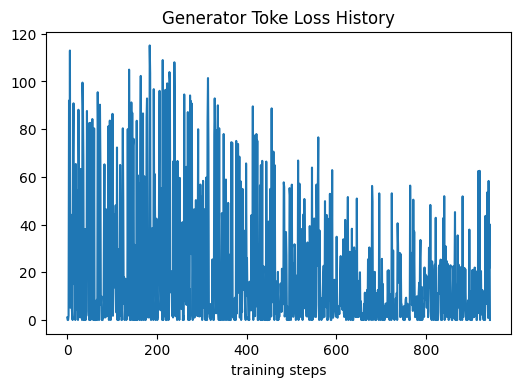

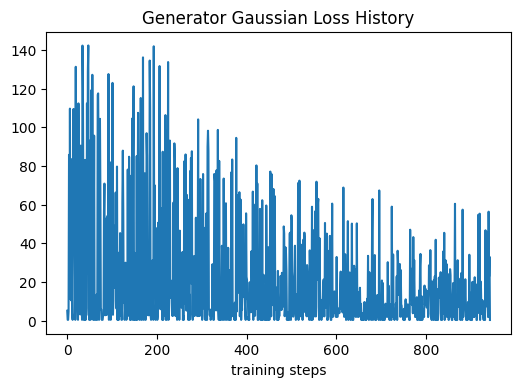

In [45]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

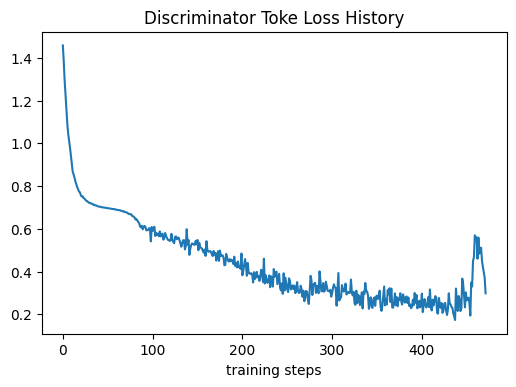

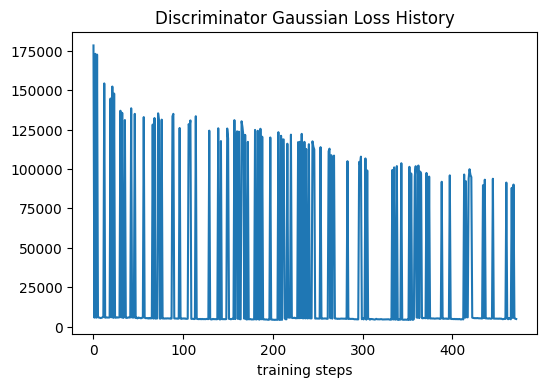

In [46]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

In [47]:
loss_save_dir = './experiment_results/after_6_epochs/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_gaussian_loss_history, f)

## 6 epochs: Save G and D models

In [49]:
G_save_dir = './experiment_results/after_6_epochs/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [50]:
D_save_dir = './experiment_results/after_6_epochs/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 6 epochs: Generate sequences 

In [51]:
N_gen = 1000 # 
generated_seqs = []

for i in tqdm(range(N_gen)):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout(generator,
                                                                                               T, EVENT_VOCAB_DIM,
                                                                                               verbose=False)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 100 == 0:
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

  0%|          | 1/1000 [00:00<09:54,  1.68it/s]

0
[(1.0, 0), (4.0, 1.0), (3.0, 3.042334395255765), (2.0, 5.193666452365816), (1.0, 6.863388674039081), (2.0, 8.704487967332835), (1.0, 10.057160360708), (2.0, 11.057160360708), (1.0, 12.057160360708), (2.0, 13.057160360708), (2.0, 14.057160360708)]


 10%|█         | 102/1000 [00:29<05:06,  2.93it/s]

100
[(1.0, 0), (2.0, 1.0), (3.0, 2.0), (2.0, 3.0), (4.0, 4.0), (1.0, 5.640937044519746), (3.0, 6.640937044519746), (1.0, 8.039135963561721), (3.0, 10.46770357652376), (4.0, 11.930605738814167), (4.0, 14.070014107180056)]


 20%|██        | 202/1000 [00:54<03:35,  3.70it/s]

200
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 30%|███       | 301/1000 [01:25<02:56,  3.97it/s]

300
[(1.0, 0), (2.0, 1.0), (1.0, 3.3444046060372195), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 40%|████      | 401/1000 [01:54<03:50,  2.60it/s]

400
[(1.0, 0), (2.0, 1.3104387431427686), (3.0, 2.3104387431427686), (3.0, 3.358547158179643), (3.0, 4.927353025966), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 50%|█████     | 501/1000 [02:22<03:16,  2.55it/s]

500
[(1.0, 0), (2.0, 1.0), (4.0, 2.0), (4.0, 3.3197132603813633), (2.0, 5.188223186748092), (4.0, 6.521257756417398), (2.0, 8.557688613048226), (2.0, 9.557688613048226), (3.0, 11.35031092754482), (0.0, 0), (0.0, 0)]


 60%|██████    | 602/1000 [02:51<02:06,  3.15it/s]

600
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 70%|███████   | 701/1000 [03:16<01:11,  4.17it/s]

700
[(1.0, 0), (1.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 80%|████████  | 801/1000 [03:47<00:45,  4.35it/s]

800
[(1.0, 0), (2.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 90%|█████████ | 901/1000 [04:14<00:32,  3.06it/s]

900
[(1.0, 0), (2.0, 1.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]


In [52]:
generated_seqs_save_dir = './experiment_results/after_6_epochs/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

# Continue Training G and D for 8 more epochs, in total 14

In [53]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=8,
                         buffer_size=N_train)

WEIGHT_GAUSSIAN_LOSS = 1e-2
_G_STEPS = 2
_D_STEPS = 1
N_total = train_features[0].shape[0]

In [54]:
_TOTAL_STEPS = int(N_total / BATCH_SIZE * 8)

step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


1it [00:51, 51.39s/it]

Training Step: 2


3it [02:30, 50.65s/it]

Training Step: 4


4it [03:20, 50.34s/it]

Training Step: 5


5it [04:15, 51.74s/it]

Training Step: 6


6it [05:04, 51.10s/it]

Training Step: 7


7it [05:53, 50.37s/it]

Training Step: 8


8it [06:44, 50.41s/it]

Training Step: 9


9it [07:37, 51.33s/it]

Training Step: 10


10it [08:28, 51.30s/it]

Training Step: 11


11it [09:19, 51.19s/it]

Training Step: 12


12it [10:17, 53.03s/it]

Training Step: 13


13it [11:03, 50.98s/it]

Training Step: 14


14it [11:56, 51.61s/it]

Training Step: 15


15it [12:43, 50.41s/it]

Training Step: 16


16it [13:34, 50.34s/it]

Training Step: 17


17it [14:27, 51.32s/it]

Training Step: 18


18it [15:16, 50.52s/it]

Training Step: 19


19it [16:11, 51.82s/it]

Training Step: 20


20it [16:57, 50.15s/it]

Training Step: 21


21it [17:51, 51.30s/it]

Training Step: 22


22it [18:38, 49.95s/it]

Training Step: 23


23it [19:32, 51.11s/it]

Training Step: 24


24it [20:21, 50.68s/it]

Training Step: 25


25it [21:13, 51.13s/it]

Training Step: 26


26it [22:02, 50.36s/it]

Training Step: 27


27it [22:54, 50.90s/it]

Training Step: 28


28it [23:44, 50.55s/it]

Training Step: 29


29it [24:37, 51.36s/it]

Training Step: 30


30it [25:27, 50.94s/it]

Training Step: 31


31it [26:19, 51.22s/it]

Training Step: 32


32it [27:13, 51.94s/it]

Training Step: 33


33it [28:03, 51.40s/it]

Training Step: 34


34it [28:52, 50.87s/it]

Training Step: 35


35it [29:45, 51.52s/it]

Training Step: 36


36it [30:44, 53.53s/it]

Training Step: 37


37it [31:33, 52.20s/it]

Training Step: 38


38it [32:21, 51.10s/it]

Training Step: 39


39it [33:18, 52.71s/it]

Training Step: 40


40it [34:10, 52.70s/it]

Training Step: 41


41it [34:59, 51.37s/it]

Training Step: 42


42it [35:47, 50.39s/it]

Training Step: 43


43it [36:41, 51.55s/it]

Training Step: 44


44it [37:28, 50.05s/it]

Training Step: 45


45it [38:20, 50.64s/it]

Training Step: 46


46it [39:14, 51.78s/it]

Training Step: 47


47it [40:08, 52.28s/it]

Training Step: 48


48it [40:57, 51.49s/it]

Training Step: 49


49it [41:49, 51.71s/it]

Training Step: 50


50it [42:42, 52.01s/it]

Training Step: 51


51it [43:34, 52.10s/it]

Training Step: 52


52it [44:21, 50.41s/it]

Training Step: 53


53it [45:17, 51.99s/it]

Training Step: 54


54it [46:05, 50.92s/it]

Training Step: 55


55it [46:58, 51.48s/it]

Training Step: 56


56it [47:49, 51.33s/it]

Training Step: 57


57it [48:39, 51.02s/it]

Training Step: 58


58it [49:30, 50.88s/it]

Training Step: 59


59it [50:24, 52.05s/it]

Training Step: 60


60it [51:15, 51.59s/it]

Training Step: 61


61it [52:07, 51.76s/it]

Training Step: 62


62it [52:58, 51.48s/it]

Training Step: 63


63it [53:46, 50.43s/it]

Training Step: 64


64it [54:38, 50.94s/it]

Training Step: 65


65it [55:30, 51.16s/it]

Training Step: 66


66it [56:23, 51.78s/it]

Training Step: 67


67it [57:20, 53.54s/it]

Training Step: 68


68it [58:10, 52.29s/it]

Training Step: 69


69it [59:01, 51.81s/it]

Training Step: 70


70it [59:53, 51.86s/it]

Training Step: 71


71it [1:00:40, 50.65s/it]

Training Step: 72


72it [1:01:28, 49.81s/it]

Training Step: 73


73it [1:02:18, 49.69s/it]

Training Step: 74


74it [1:03:13, 51.43s/it]

Training Step: 75


75it [1:04:02, 50.57s/it]

Training Step: 76


76it [1:04:54, 50.99s/it]

Training Step: 77


77it [1:05:44, 50.72s/it]

Training Step: 78


78it [1:06:38, 51.78s/it]

Training Step: 79


79it [1:07:29, 51.58s/it]

Training Step: 80


80it [1:08:27, 53.52s/it]

Training Step: 81


81it [1:09:15, 51.80s/it]

Training Step: 82


82it [1:10:03, 50.70s/it]

Training Step: 83


83it [1:10:56, 51.24s/it]

Training Step: 84


84it [1:11:45, 50.58s/it]

Training Step: 85


85it [1:12:39, 51.63s/it]

Training Step: 86


86it [1:13:27, 50.74s/it]

Training Step: 87


87it [1:14:19, 51.06s/it]

Training Step: 88


88it [1:15:12, 51.45s/it]

Training Step: 89


89it [1:16:06, 52.45s/it]

Training Step: 90


90it [1:17:01, 52.99s/it]

Training Step: 91


91it [1:17:50, 51.79s/it]

Training Step: 92


92it [1:18:37, 50.40s/it]

Training Step: 93


93it [1:19:28, 50.56s/it]

Training Step: 94


94it [1:20:21, 51.34s/it]

Training Step: 95


95it [1:21:13, 51.73s/it]

Training Step: 96


96it [1:22:02, 50.89s/it]

Training Step: 97


97it [1:22:54, 51.13s/it]

Training Step: 98


98it [1:23:50, 52.47s/it]

Training Step: 99


99it [1:24:38, 51.20s/it]

Training Step: 100


100it [1:25:31, 51.85s/it]

Training Step: 101


101it [1:26:24, 52.20s/it]

Training Step: 102


102it [1:27:14, 51.48s/it]

Training Step: 103


103it [1:28:09, 52.53s/it]

Training Step: 104


104it [1:29:01, 52.44s/it]

Training Step: 105


105it [1:29:54, 52.59s/it]

Training Step: 106


106it [1:30:46, 52.23s/it]

Training Step: 107


107it [1:31:34, 51.23s/it]

Training Step: 108


108it [1:32:28, 51.83s/it]

Training Step: 109


109it [1:33:19, 51.67s/it]

Training Step: 110


110it [1:34:07, 50.69s/it]

Training Step: 111


111it [1:34:57, 50.50s/it]

Training Step: 112


112it [1:35:50, 51.04s/it]

Training Step: 113


113it [1:36:40, 50.66s/it]

Training Step: 114


114it [1:37:31, 50.86s/it]

Training Step: 115


115it [1:38:22, 50.90s/it]

Training Step: 116


116it [1:39:13, 50.90s/it]

Training Step: 117


117it [1:39:59, 49.62s/it]

Training Step: 118


118it [1:40:50, 49.82s/it]

Training Step: 119


119it [1:41:44, 51.12s/it]

Training Step: 120


120it [1:42:32, 50.32s/it]

Training Step: 121


121it [1:43:24, 50.65s/it]

Training Step: 122


122it [1:44:18, 51.77s/it]

Training Step: 123


123it [1:45:08, 51.25s/it]

Training Step: 124


124it [1:45:55, 49.89s/it]

Training Step: 125


125it [1:46:45, 50.11s/it]

Training Step: 126


126it [1:47:35, 49.94s/it]

Training Step: 127


127it [1:48:22, 49.14s/it]

Training Step: 128


128it [1:49:12, 49.23s/it]

Training Step: 129


129it [1:50:03, 49.71s/it]

Training Step: 130


130it [1:51:04, 53.28s/it]

Training Step: 131


131it [1:51:52, 51.70s/it]

Training Step: 132


132it [1:52:40, 50.43s/it]

Training Step: 133


133it [1:53:39, 52.97s/it]

Training Step: 134


134it [1:54:34, 53.62s/it]

Training Step: 135


135it [1:55:22, 51.94s/it]

Training Step: 136


136it [1:56:15, 52.35s/it]

Training Step: 137


137it [1:57:12, 53.63s/it]

Training Step: 138


138it [1:58:00, 51.99s/it]

Training Step: 139


139it [1:58:55, 52.92s/it]

Training Step: 140


140it [1:59:45, 52.13s/it]

Training Step: 141


141it [2:00:40, 52.97s/it]

Training Step: 142


142it [2:01:34, 53.39s/it]

Training Step: 143


143it [2:02:27, 53.25s/it]

Training Step: 144


144it [2:03:22, 53.58s/it]

Training Step: 145


145it [2:04:13, 52.99s/it]

Training Step: 146


146it [2:05:05, 52.60s/it]

Training Step: 147


147it [2:05:59, 52.95s/it]

Training Step: 148


148it [2:06:50, 52.55s/it]

Training Step: 149


149it [2:07:45, 53.15s/it]

Training Step: 150


150it [2:08:39, 53.41s/it]

Training Step: 151


151it [2:09:30, 52.79s/it]

Training Step: 152


152it [2:10:21, 52.13s/it]

Training Step: 153


153it [2:11:14, 52.42s/it]

Training Step: 154


154it [2:12:07, 52.50s/it]

Training Step: 155


155it [2:13:01, 52.99s/it]

Training Step: 156


156it [2:13:52, 52.51s/it]

Training Step: 157


157it [2:14:44, 52.14s/it]

Training Step: 158


158it [2:15:43, 54.39s/it]

Training Step: 159


159it [2:16:35, 53.60s/it]

Training Step: 160


160it [2:17:31, 54.39s/it]

Training Step: 161


161it [2:18:24, 53.88s/it]

Training Step: 162


162it [2:19:17, 53.75s/it]

Training Step: 163


163it [2:20:10, 53.50s/it]

Training Step: 164


164it [2:20:57, 51.40s/it]

Training Step: 165


165it [2:21:49, 51.58s/it]

Training Step: 166


166it [2:22:42, 52.12s/it]

Training Step: 167


167it [2:23:34, 52.00s/it]

Training Step: 168


168it [2:24:27, 52.34s/it]

Training Step: 169


169it [2:25:17, 51.76s/it]

Training Step: 170


170it [2:26:12, 52.69s/it]

Training Step: 171


171it [2:27:05, 52.76s/it]

Training Step: 172


172it [2:28:00, 53.48s/it]

Training Step: 173


173it [2:28:54, 53.57s/it]

Training Step: 174


174it [2:29:48, 53.61s/it]

Training Step: 175


175it [2:30:41, 53.54s/it]

Training Step: 176


176it [2:31:31, 52.31s/it]

Training Step: 177


177it [2:32:23, 52.39s/it]

Training Step: 178


178it [2:33:18, 52.97s/it]

Training Step: 179


179it [2:34:08, 52.29s/it]

Training Step: 180


180it [2:34:58, 51.51s/it]

Training Step: 181


181it [2:35:47, 50.82s/it]

Training Step: 182


182it [2:36:40, 51.50s/it]

Training Step: 183


183it [2:37:28, 50.47s/it]

Training Step: 184


184it [2:38:21, 51.25s/it]

Training Step: 185


185it [2:39:11, 50.67s/it]

Training Step: 186


186it [2:40:06, 52.23s/it]

Training Step: 187


187it [2:40:59, 52.34s/it]

Training Step: 188


188it [2:41:49, 51.62s/it]

Training Step: 189


189it [2:42:36, 50.27s/it]

Training Step: 190


190it [2:43:27, 50.56s/it]

Training Step: 191


191it [2:44:21, 51.38s/it]

Training Step: 192


192it [2:45:09, 50.41s/it]

Training Step: 193


193it [2:46:05, 52.09s/it]

Training Step: 194


194it [2:46:56, 51.86s/it]

Training Step: 195


195it [2:47:46, 51.29s/it]

Training Step: 196


196it [2:48:33, 49.88s/it]

Training Step: 197


197it [2:49:20, 48.95s/it]

Training Step: 198


198it [2:50:09, 49.05s/it]

Training Step: 199


199it [2:51:02, 50.16s/it]

Training Step: 200


200it [2:51:53, 50.55s/it]

Training Step: 201


201it [2:52:44, 50.83s/it]

Training Step: 202


202it [2:53:32, 49.92s/it]

Training Step: 203


203it [2:54:30, 52.19s/it]

Training Step: 204


204it [2:55:18, 50.86s/it]

Training Step: 205


205it [2:56:14, 52.45s/it]

Training Step: 206


206it [2:57:10, 53.52s/it]

Training Step: 207


207it [2:58:01, 52.95s/it]

Training Step: 208


208it [2:58:54, 52.87s/it]

Training Step: 209


209it [2:59:45, 52.39s/it]

Training Step: 210


210it [3:00:36, 51.97s/it]

Training Step: 211


211it [3:01:29, 52.24s/it]

Training Step: 212


212it [3:02:21, 52.06s/it]

Training Step: 213


213it [3:03:13, 51.97s/it]

Training Step: 214


214it [3:04:05, 52.07s/it]

Training Step: 215


215it [3:04:58, 52.32s/it]

Training Step: 216


216it [3:05:58, 54.74s/it]

Training Step: 217


217it [3:06:48, 53.43s/it]

Training Step: 218


218it [3:07:37, 52.04s/it]

Training Step: 219


219it [3:08:26, 51.00s/it]

Training Step: 220


220it [3:09:20, 52.07s/it]

Training Step: 221


221it [3:10:13, 52.34s/it]

Training Step: 222


222it [3:11:02, 51.34s/it]

Training Step: 223


223it [3:11:50, 50.09s/it]

Training Step: 224


224it [3:12:43, 50.95s/it]

Training Step: 225


225it [3:13:33, 50.95s/it]

Training Step: 226


226it [3:14:31, 52.82s/it]

Training Step: 227


227it [3:15:26, 53.44s/it]

Training Step: 228


228it [3:16:17, 52.89s/it]

Training Step: 229


229it [3:17:12, 53.41s/it]

Training Step: 230


230it [3:18:02, 52.51s/it]

Training Step: 231


231it [3:18:53, 52.14s/it]

Training Step: 232


232it [3:19:45, 51.87s/it]

Training Step: 233


233it [3:20:36, 51.56s/it]

Training Step: 234


234it [3:21:25, 50.93s/it]

Training Step: 235


235it [3:22:08, 48.57s/it]

Training Step: 236


236it [3:22:56, 48.31s/it]

Training Step: 237


237it [3:23:46, 48.86s/it]

Training Step: 238


238it [3:24:32, 48.01s/it]

Training Step: 239


239it [3:25:25, 49.48s/it]

Training Step: 240


240it [3:26:17, 50.21s/it]

Training Step: 241


241it [3:27:07, 50.36s/it]

Training Step: 242


242it [3:28:04, 52.25s/it]

Training Step: 243


243it [3:28:56, 52.22s/it]

Training Step: 244


244it [3:29:49, 52.42s/it]

Training Step: 245


245it [3:30:45, 53.52s/it]

Training Step: 246


246it [3:31:38, 53.20s/it]

Training Step: 247


247it [3:32:30, 53.07s/it]

Training Step: 248


248it [3:33:28, 54.39s/it]

Training Step: 249


249it [3:34:20, 53.65s/it]

Training Step: 250


250it [3:35:10, 52.59s/it]

Training Step: 251


251it [3:36:02, 52.54s/it]

Training Step: 252


252it [3:36:55, 52.69s/it]

Training Step: 253


253it [3:37:51, 53.57s/it]

Training Step: 254


254it [3:38:37, 51.32s/it]

Training Step: 255


255it [3:39:35, 53.32s/it]

Training Step: 256


256it [3:40:25, 52.29s/it]

Training Step: 257


257it [3:41:20, 53.06s/it]

Training Step: 258


258it [3:42:12, 52.88s/it]

Training Step: 259


259it [3:43:03, 52.18s/it]

Training Step: 260


260it [3:43:49, 50.34s/it]

Training Step: 261


261it [3:44:43, 51.49s/it]

Training Step: 262


262it [3:45:37, 52.18s/it]

Training Step: 263


263it [3:46:27, 51.55s/it]

Training Step: 264


264it [3:47:25, 53.39s/it]

Training Step: 265


265it [3:48:18, 53.35s/it]

Training Step: 266


266it [3:49:12, 53.47s/it]

Training Step: 267


267it [3:50:01, 52.15s/it]

Training Step: 268


268it [3:50:50, 51.25s/it]

Training Step: 269


269it [3:51:45, 52.32s/it]

Training Step: 270


270it [3:52:34, 51.36s/it]

Training Step: 271


271it [3:53:30, 52.85s/it]

Training Step: 272


272it [3:54:28, 54.25s/it]

Training Step: 273


273it [3:55:16, 52.34s/it]

Training Step: 274


274it [3:56:09, 52.56s/it]

Training Step: 275


275it [3:56:56, 51.08s/it]

Training Step: 276


276it [3:57:49, 51.55s/it]

Training Step: 277


277it [3:58:40, 51.56s/it]

Training Step: 278


278it [3:59:35, 52.39s/it]

Training Step: 279


279it [4:00:34, 54.53s/it]

Training Step: 280


280it [4:01:24, 53.06s/it]

Training Step: 281


281it [4:02:17, 53.06s/it]

Training Step: 282


282it [4:03:07, 52.00s/it]

Training Step: 283


283it [4:03:56, 51.11s/it]

Training Step: 284


284it [4:04:44, 50.28s/it]

Training Step: 285


285it [4:05:30, 49.12s/it]

Training Step: 286


286it [4:06:23, 50.29s/it]

Training Step: 287


287it [4:07:25, 53.62s/it]

Training Step: 288


288it [4:08:14, 52.28s/it]

Training Step: 289


289it [4:09:09, 53.05s/it]

Training Step: 290


290it [4:09:58, 51.98s/it]

Training Step: 291


291it [4:10:53, 52.76s/it]

Training Step: 292


292it [4:11:45, 52.72s/it]

Training Step: 293


293it [4:12:38, 52.69s/it]

Training Step: 294


294it [4:13:27, 51.62s/it]

Training Step: 295


295it [4:14:20, 51.93s/it]

Training Step: 296


296it [4:15:10, 51.54s/it]

Training Step: 297


297it [4:16:02, 51.39s/it]

Training Step: 298


298it [4:16:57, 52.73s/it]

Training Step: 299


299it [4:17:52, 53.26s/it]

Training Step: 300


300it [4:18:40, 51.65s/it]

Training Step: 301


301it [4:19:30, 51.21s/it]

Training Step: 302


302it [4:20:20, 50.85s/it]

Training Step: 303


303it [4:21:16, 52.51s/it]

Training Step: 304


304it [4:22:11, 53.14s/it]

Training Step: 305


305it [4:23:03, 52.92s/it]

Training Step: 306


306it [4:24:01, 54.30s/it]

Training Step: 307


307it [4:24:56, 54.49s/it]

Training Step: 308


308it [4:25:49, 54.06s/it]

Training Step: 309


309it [4:26:42, 53.83s/it]

Training Step: 310


310it [4:27:34, 53.29s/it]

Training Step: 311


311it [4:28:26, 52.74s/it]

Training Step: 312


312it [4:29:11, 50.60s/it]

Training Step: 313


313it [4:30:01, 50.24s/it]

Training Step: 314


314it [4:30:54, 51.32s/it]

Training Step: 315


315it [4:31:41, 50.02s/it]

Training Step: 316


316it [4:32:32, 50.03s/it]

Training Step: 317


317it [4:33:18, 49.08s/it]

Training Step: 318


318it [4:34:11, 50.17s/it]

Training Step: 319


319it [4:34:57, 48.78s/it]

Training Step: 320


320it [4:35:54, 51.41s/it]

Training Step: 321


321it [4:36:48, 52.05s/it]

Training Step: 322


322it [4:37:35, 50.67s/it]

Training Step: 323


323it [4:38:28, 51.26s/it]

Training Step: 324


324it [4:39:17, 50.62s/it]

Training Step: 325


325it [4:40:07, 50.57s/it]

Training Step: 326


326it [4:41:03, 52.00s/it]

Training Step: 327


327it [4:41:54, 51.86s/it]

Training Step: 328


328it [4:42:42, 50.62s/it]

Training Step: 329


329it [4:43:36, 51.78s/it]

Training Step: 330


330it [4:44:26, 51.05s/it]

Training Step: 331


331it [4:45:24, 53.22s/it]

Training Step: 332


332it [4:46:14, 52.30s/it]

Training Step: 333


333it [4:47:06, 52.08s/it]

Training Step: 334


334it [4:47:57, 51.94s/it]

Training Step: 335


335it [4:48:54, 53.42s/it]

Training Step: 336


336it [4:49:50, 54.09s/it]

Training Step: 337


337it [4:50:41, 53.31s/it]

Training Step: 338


338it [4:51:30, 51.82s/it]

Training Step: 339


339it [4:52:24, 52.52s/it]

Training Step: 340


340it [4:53:16, 52.40s/it]

Training Step: 341


341it [4:54:08, 52.14s/it]

Training Step: 342


342it [4:54:59, 51.84s/it]

Training Step: 343


343it [4:55:49, 51.35s/it]

Training Step: 344


344it [4:56:43, 52.26s/it]

Training Step: 345


345it [4:57:37, 52.78s/it]

Training Step: 346


346it [4:58:29, 52.48s/it]

Training Step: 347


347it [4:59:27, 53.98s/it]

Training Step: 348


348it [5:00:22, 54.54s/it]

Training Step: 349


349it [5:01:16, 54.28s/it]

Training Step: 350


350it [5:02:07, 53.12s/it]

Training Step: 351


351it [5:02:57, 52.44s/it]

Training Step: 352


352it [5:03:57, 54.65s/it]

Training Step: 353


353it [5:04:49, 53.75s/it]

Training Step: 354


354it [5:05:41, 53.19s/it]

Training Step: 355


355it [5:06:29, 51.69s/it]

Training Step: 356


356it [5:07:22, 52.22s/it]

Training Step: 357


357it [5:08:15, 52.31s/it]

Training Step: 358


358it [5:09:00, 50.22s/it]

Training Step: 359


359it [5:09:54, 51.21s/it]

Training Step: 360


360it [5:10:48, 52.19s/it]

Training Step: 361


361it [5:11:41, 52.42s/it]

Training Step: 362


362it [5:12:34, 52.59s/it]

Training Step: 363


363it [5:13:27, 52.73s/it]

Training Step: 364


364it [5:14:20, 52.65s/it]

Training Step: 365


365it [5:15:13, 52.97s/it]

Training Step: 366


366it [5:15:59, 50.89s/it]

Training Step: 367


367it [5:16:56, 52.67s/it]

Training Step: 368


368it [5:17:47, 51.94s/it]

Training Step: 369


369it [5:18:38, 51.88s/it]

Training Step: 370


370it [5:19:28, 51.31s/it]

Training Step: 371


371it [5:20:23, 52.37s/it]

Training Step: 372


372it [5:21:17, 52.76s/it]

Training Step: 373


373it [5:22:06, 51.72s/it]

Training Step: 374


374it [5:22:53, 50.18s/it]

Training Step: 375


375it [5:23:48, 51.67s/it]

Training Step: 376


376it [5:24:39, 51.55s/it]

Training Step: 377


377it [5:25:31, 51.79s/it]

Training Step: 378


378it [5:26:24, 52.16s/it]

Training Step: 379


379it [5:27:19, 52.83s/it]

Training Step: 380


380it [5:28:11, 52.52s/it]

Training Step: 381


381it [5:28:59, 51.26s/it]

Training Step: 382


382it [5:29:54, 52.41s/it]

Training Step: 383


383it [5:30:47, 52.73s/it]

Training Step: 384


384it [5:31:37, 51.68s/it]

Training Step: 385


385it [5:32:31, 52.34s/it]

Training Step: 386


386it [5:33:23, 52.31s/it]

Training Step: 387


387it [5:34:13, 51.73s/it]

Training Step: 388


388it [5:35:07, 52.38s/it]

Training Step: 389


389it [5:36:02, 53.24s/it]

Training Step: 390


390it [5:36:57, 53.55s/it]

Training Step: 391


391it [5:37:52, 53.98s/it]

Training Step: 392


392it [5:38:40, 52.25s/it]

Training Step: 393


393it [5:39:32, 52.23s/it]

Training Step: 394


394it [5:40:24, 52.18s/it]

Training Step: 395


395it [5:41:15, 51.88s/it]

Training Step: 396


396it [5:42:06, 51.62s/it]

Training Step: 397


397it [5:42:56, 51.11s/it]

Training Step: 398


398it [5:43:47, 51.14s/it]

Training Step: 399


399it [5:44:41, 51.89s/it]

Training Step: 400


400it [5:45:37, 53.18s/it]

Training Step: 401


401it [5:46:33, 53.94s/it]

Training Step: 402


402it [5:47:23, 52.71s/it]

Training Step: 403


403it [5:48:13, 51.89s/it]

Training Step: 404


404it [5:49:05, 51.92s/it]

Training Step: 405


405it [5:49:58, 52.40s/it]

Training Step: 406


406it [5:50:48, 51.65s/it]

Training Step: 407


407it [5:51:44, 53.00s/it]

Training Step: 408


408it [5:52:35, 52.23s/it]

Training Step: 409


409it [5:53:23, 51.02s/it]

Training Step: 410


410it [5:54:14, 51.14s/it]

Training Step: 411


411it [5:55:12, 53.22s/it]

Training Step: 412


412it [5:56:02, 51.97s/it]

Training Step: 413


413it [5:56:51, 51.09s/it]

Training Step: 414


414it [5:57:38, 50.00s/it]

Training Step: 415


415it [5:58:28, 49.94s/it]

Training Step: 416


416it [5:59:18, 50.01s/it]

Training Step: 417


417it [6:00:08, 49.90s/it]

Training Step: 418


418it [6:00:54, 48.86s/it]

Training Step: 419


419it [6:01:47, 49.93s/it]

Training Step: 420


420it [6:02:38, 50.29s/it]

Training Step: 421


421it [6:03:30, 51.04s/it]

Training Step: 422


422it [6:04:22, 51.11s/it]

Training Step: 423


423it [6:05:13, 51.15s/it]

Training Step: 424


424it [6:06:06, 51.61s/it]

Training Step: 425


425it [6:07:00, 52.31s/it]

Training Step: 426


426it [6:07:57, 53.94s/it]

Training Step: 427


427it [6:08:50, 53.64s/it]

Training Step: 428


428it [6:09:39, 52.17s/it]

Training Step: 429


429it [6:10:29, 51.48s/it]

Training Step: 430


430it [6:11:15, 49.87s/it]

Training Step: 431


431it [6:12:13, 52.39s/it]

Training Step: 432


432it [6:13:07, 52.94s/it]

Training Step: 433


433it [6:14:01, 52.99s/it]

Training Step: 434


434it [6:14:57, 53.91s/it]

Training Step: 435


435it [6:15:48, 53.20s/it]

Training Step: 436


436it [6:16:38, 52.24s/it]

Training Step: 437


437it [6:17:27, 51.26s/it]

Training Step: 438


438it [6:18:20, 51.86s/it]

Training Step: 439


439it [6:19:12, 51.90s/it]

Training Step: 440


440it [6:20:04, 51.76s/it]

Training Step: 441


441it [6:20:54, 51.33s/it]

Training Step: 442


442it [6:21:46, 51.43s/it]

Training Step: 443


443it [6:22:38, 51.80s/it]

Training Step: 444


444it [6:23:31, 52.12s/it]

Training Step: 445


445it [6:24:28, 53.52s/it]

Training Step: 446


446it [6:25:22, 53.65s/it]

Training Step: 447


447it [6:26:21, 55.33s/it]

Training Step: 448


448it [6:27:15, 54.80s/it]

Training Step: 449


449it [6:28:06, 53.67s/it]

Training Step: 450


450it [6:28:54, 52.01s/it]

Training Step: 451


451it [6:29:46, 51.84s/it]

Training Step: 452


452it [6:30:40, 52.55s/it]

Training Step: 453


453it [6:31:29, 51.57s/it]

Training Step: 454


454it [6:32:22, 52.10s/it]

Training Step: 455


455it [6:33:14, 52.04s/it]

Training Step: 456


456it [6:34:02, 50.90s/it]

Training Step: 457


457it [6:34:51, 50.14s/it]

Training Step: 458


458it [6:35:45, 51.21s/it]

Training Step: 459


459it [6:36:39, 52.11s/it]

Training Step: 460


460it [6:37:32, 52.42s/it]

Training Step: 461


461it [6:38:25, 52.62s/it]

Training Step: 462


462it [6:39:19, 53.15s/it]

Training Step: 463


463it [6:40:08, 51.64s/it]

Training Step: 464


464it [6:40:58, 51.40s/it]

Training Step: 465


465it [6:41:45, 49.96s/it]

Training Step: 466


466it [6:42:34, 49.63s/it]

Training Step: 467


467it [6:43:28, 50.91s/it]

Training Step: 468


468it [6:44:23, 52.32s/it]

Training Step: 469


469it [6:45:14, 51.82s/it]

Training Step: 470


470it [6:46:08, 52.41s/it]

Training Step: 471


471it [6:46:58, 51.70s/it]

Training Step: 472


472it [6:47:54, 53.05s/it]

Training Step: 473


473it [6:48:41, 51.26s/it]

Training Step: 474


474it [6:49:30, 50.58s/it]

Training Step: 475


475it [6:50:23, 51.25s/it]

Training Step: 476


476it [6:51:18, 52.49s/it]

Training Step: 477


477it [6:52:09, 51.84s/it]

Training Step: 478


478it [6:53:03, 52.52s/it]

Training Step: 479


479it [6:53:56, 52.70s/it]

Training Step: 480


480it [6:54:42, 50.79s/it]

Training Step: 481


481it [6:55:31, 50.19s/it]

Training Step: 482


482it [6:56:21, 50.11s/it]

Training Step: 483


483it [6:57:15, 51.19s/it]

Training Step: 484


484it [6:58:08, 51.76s/it]

Training Step: 485


485it [6:59:01, 52.19s/it]

Training Step: 486


486it [6:59:51, 51.47s/it]

Training Step: 487


487it [7:00:42, 51.48s/it]

Training Step: 488


488it [7:01:34, 51.57s/it]

Training Step: 489


489it [7:02:28, 52.28s/it]

Training Step: 490


490it [7:03:23, 53.18s/it]

Training Step: 491


491it [7:04:17, 53.45s/it]

Training Step: 492


492it [7:05:13, 54.05s/it]

Training Step: 493


493it [7:06:11, 55.42s/it]

Training Step: 494


494it [7:07:02, 54.07s/it]

Training Step: 495


495it [7:07:57, 54.27s/it]

Training Step: 496


496it [7:08:48, 53.39s/it]

Training Step: 497


497it [7:09:37, 52.12s/it]

Training Step: 498


498it [7:10:28, 51.70s/it]

Training Step: 499


499it [7:11:21, 52.12s/it]

Training Step: 500


500it [7:12:11, 51.35s/it]

Training Step: 501


501it [7:12:56, 49.48s/it]

Training Step: 502


502it [7:13:53, 51.66s/it]

Training Step: 503


503it [7:14:48, 52.83s/it]

Training Step: 504


504it [7:15:36, 51.27s/it]

Training Step: 505


505it [7:16:30, 52.21s/it]

Training Step: 506


506it [7:17:22, 52.16s/it]

Training Step: 507


507it [7:18:16, 52.57s/it]

Training Step: 508


508it [7:19:10, 53.15s/it]

Training Step: 509


509it [7:20:00, 52.06s/it]

Training Step: 510


510it [7:20:49, 51.16s/it]

Training Step: 511


511it [7:21:42, 51.76s/it]

Training Step: 512


512it [7:22:34, 51.84s/it]

Training Step: 513


513it [7:23:30, 53.19s/it]

Training Step: 514


514it [7:24:22, 52.84s/it]

Training Step: 515


515it [7:25:18, 53.74s/it]

Training Step: 516


516it [7:26:09, 52.79s/it]

Training Step: 517


517it [7:27:07, 54.35s/it]

Training Step: 518


518it [7:28:02, 54.47s/it]

Training Step: 519


519it [7:28:51, 52.98s/it]

Training Step: 520


520it [7:29:43, 52.52s/it]

Training Step: 521


521it [7:30:35, 52.60s/it]

Training Step: 522


522it [7:31:20, 50.33s/it]

Training Step: 523


523it [7:32:17, 52.21s/it]

Training Step: 524


524it [7:33:10, 52.37s/it]

Training Step: 525


525it [7:34:05, 53.40s/it]

Training Step: 526


526it [7:34:59, 53.44s/it]

Training Step: 527


527it [7:35:59, 55.42s/it]

Training Step: 528


528it [7:36:53, 54.84s/it]

Training Step: 529


529it [7:37:54, 56.81s/it]

Training Step: 530


530it [7:38:50, 56.68s/it]

Training Step: 531


531it [7:39:44, 55.65s/it]

Training Step: 532


532it [7:40:43, 56.67s/it]

Training Step: 533


533it [7:41:39, 56.51s/it]

Training Step: 534


534it [7:42:38, 57.42s/it]

Training Step: 535


535it [7:43:26, 54.56s/it]

Training Step: 536


536it [7:44:18, 53.77s/it]

Training Step: 537


537it [7:45:11, 53.54s/it]

Training Step: 538


538it [7:46:00, 52.25s/it]

Training Step: 539


539it [7:46:49, 51.16s/it]

Training Step: 540


540it [7:47:43, 51.89s/it]

Training Step: 541


541it [7:48:36, 52.47s/it]

Training Step: 542


542it [7:49:30, 52.66s/it]

Training Step: 543


543it [7:50:20, 52.02s/it]

Training Step: 544


544it [7:51:09, 51.18s/it]

Training Step: 545


545it [7:52:03, 51.91s/it]

Training Step: 546


546it [7:52:52, 51.11s/it]

Training Step: 547


547it [7:53:48, 52.54s/it]

Training Step: 548


548it [7:54:36, 51.21s/it]

Training Step: 549


549it [7:55:25, 50.61s/it]

Training Step: 550


550it [7:56:10, 48.81s/it]

Training Step: 551


551it [7:57:06, 50.93s/it]

Training Step: 552


552it [7:58:00, 51.83s/it]

Training Step: 553


553it [7:58:50, 51.33s/it]

Training Step: 554


554it [7:59:43, 51.72s/it]

Training Step: 555


555it [8:00:36, 52.19s/it]

Training Step: 556


556it [8:01:29, 52.46s/it]

Training Step: 557


557it [8:02:25, 53.70s/it]

Training Step: 558


558it [8:03:15, 52.57s/it]

Training Step: 559


559it [8:04:10, 53.18s/it]

Training Step: 560


560it [8:05:04, 53.31s/it]

Training Step: 561


561it [8:05:58, 53.59s/it]

Training Step: 562


562it [8:06:50, 53.26s/it]

Training Step: 563


563it [8:07:41, 52.44s/it]

Training Step: 564


564it [8:08:31, 51.70s/it]

Training Step: 565


565it [8:09:22, 51.60s/it]

Training Step: 566


566it [8:10:17, 52.53s/it]

Training Step: 567


567it [8:11:12, 53.30s/it]

Training Step: 568


568it [8:12:05, 53.20s/it]

Training Step: 569


569it [8:13:02, 54.45s/it]

Training Step: 570


570it [8:13:53, 53.28s/it]

Training Step: 571


571it [8:14:46, 53.18s/it]

Training Step: 572


572it [8:15:36, 52.39s/it]

Training Step: 573


573it [8:16:28, 52.06s/it]

Training Step: 574


574it [8:17:19, 51.73s/it]

Training Step: 575


575it [8:18:09, 51.21s/it]

Training Step: 576


576it [8:19:03, 52.06s/it]

Training Step: 577


577it [8:19:55, 52.13s/it]

Training Step: 578


578it [8:20:42, 50.50s/it]

Training Step: 579


579it [8:21:34, 50.91s/it]

Training Step: 580


580it [8:22:23, 50.46s/it]

Training Step: 581


581it [8:23:14, 50.76s/it]

Training Step: 582


582it [8:24:04, 50.43s/it]

Training Step: 583


583it [8:24:56, 50.94s/it]

Training Step: 584


584it [8:25:49, 51.49s/it]

Training Step: 585


585it [8:26:39, 51.03s/it]

Training Step: 586


586it [8:27:35, 52.64s/it]

Training Step: 587


587it [8:28:24, 51.58s/it]

Training Step: 588


588it [8:29:19, 52.47s/it]

Training Step: 589


589it [8:30:13, 53.00s/it]

Training Step: 590


590it [8:31:00, 51.27s/it]

Training Step: 591


591it [8:31:50, 50.65s/it]

Training Step: 592


592it [8:32:38, 49.93s/it]

Training Step: 593


593it [8:33:24, 48.80s/it]

Training Step: 594


594it [8:34:18, 50.29s/it]

Training Step: 595


595it [8:35:12, 51.40s/it]

Training Step: 596


596it [8:36:04, 51.61s/it]

Training Step: 597


597it [8:36:57, 52.00s/it]

Training Step: 598


598it [8:37:44, 50.62s/it]

Training Step: 599


599it [8:38:40, 52.19s/it]

Training Step: 600


600it [8:39:30, 51.37s/it]

Training Step: 601


601it [8:40:18, 50.43s/it]

Training Step: 602


602it [8:41:09, 50.65s/it]

Training Step: 603


603it [8:42:02, 51.41s/it]

Training Step: 604


604it [8:42:57, 52.55s/it]

Training Step: 605


605it [8:43:51, 53.02s/it]

Training Step: 606


606it [8:44:47, 53.70s/it]

Training Step: 607


607it [8:45:38, 52.91s/it]

Training Step: 608


608it [8:46:32, 53.21s/it]

Training Step: 609


609it [8:47:23, 52.66s/it]

Training Step: 610


610it [8:48:15, 52.54s/it]

Training Step: 611


611it [8:49:08, 52.54s/it]

Training Step: 612


612it [8:50:02, 52.89s/it]

Training Step: 613


613it [8:50:57, 53.76s/it]

Training Step: 614


614it [8:51:51, 53.70s/it]

Training Step: 615


615it [8:52:44, 53.62s/it]

Training Step: 616


616it [8:53:35, 52.64s/it]

Training Step: 617


617it [8:54:26, 52.24s/it]

Training Step: 618


618it [8:55:18, 52.06s/it]

Training Step: 619


619it [8:56:13, 53.01s/it]

Training Step: 620


620it [8:57:13, 55.12s/it]

Training Step: 621


621it [8:58:05, 54.11s/it]

Training Step: 622


622it [8:58:51, 51.62s/it]

Training Step: 623


623it [8:59:45, 52.40s/it]

Training Step: 624


624it [9:00:42, 53.91s/it]

Training Step: 625


625it [9:01:28, 51.98s/it]


## 14 epochs: Loss over training 

Text(0.5, 0, 'training steps')

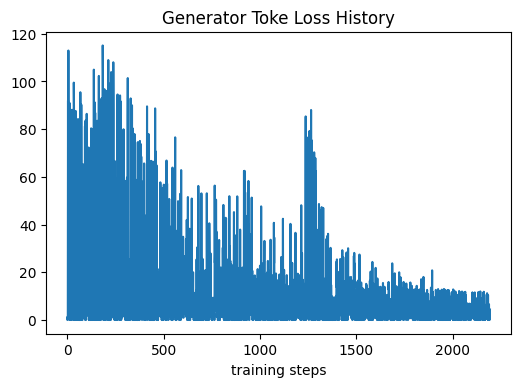

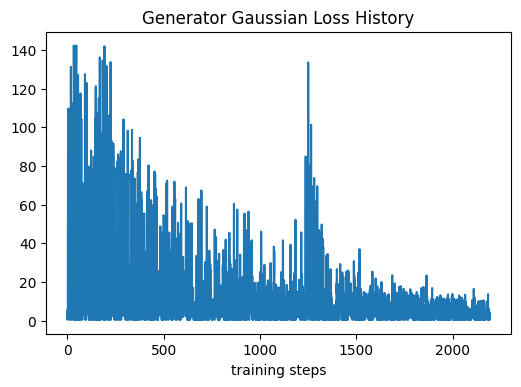

In [55]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

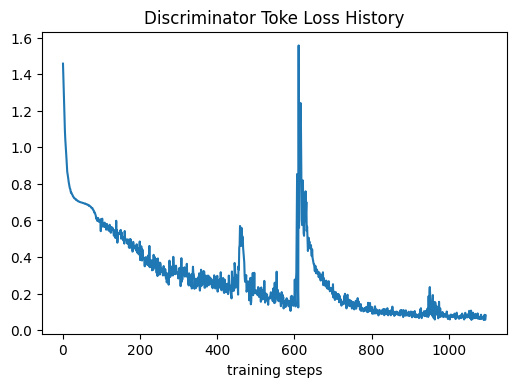

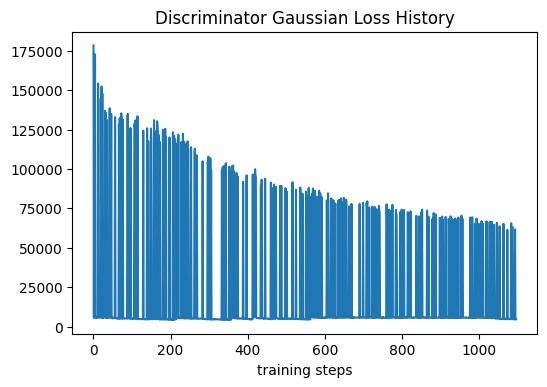

In [56]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

In [57]:
loss_save_dir = './experiment_results/after_14_epochs/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_gaussian_loss_history, f)

## 14 epochs: save G and D

In [58]:
G_save_dir = './experiment_results/after_14_epochs/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [59]:
D_save_dir = './experiment_results/after_14_epochs/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 14 epochs: Generate Sequences

In [61]:
N_gen = 1000 # 
generated_seqs = []

for i in tqdm(range(N_gen)):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout(generator,
                                                                                               T, EVENT_VOCAB_DIM,
                                                                                               verbose=False)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 100 == 0:
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

  0%|          | 0/1000 [00:00<?, ?it/s]

0
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 10%|█         | 102/1000 [00:28<04:21,  3.44it/s]

100
[(1.0, 0), (3.0, 1.0), (4.0, 2.489225747070668), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 20%|██        | 200/1000 [00:57<06:01,  2.21it/s]

200
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 30%|███       | 301/1000 [01:30<02:52,  4.06it/s]

300
[(1.0, 0), (4.0, 1.0), (3.0, 2.801125611742537), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 40%|████      | 402/1000 [01:59<03:16,  3.04it/s]

400
[(1.0, 0), (2.0, 1.0), (2.0, 3.171371244287508), (4.0, 4.171371244287508), (4.0, 5.446070148205463), (2.0, 6.446070148205463), (2.0, 8.986571487748378), (1.0, 10.141982561928819), (4.0, 11.141982561928819), (4.0, 13.815523878900317), (0.0, 0)]


 50%|█████     | 502/1000 [02:28<02:42,  3.07it/s]

500
[(1.0, 0), (3.0, 1.0), (3.0, 2.0), (4.0, 3.0), (2.0, 4.855102273268926), (3.0, 5.855102273268926), (3.0, 6.855102273268926), (4.0, 9.927544390582584), (2.0, 10.927544390582584), (1.0, 13.046216896939752), (2.0, 16.201520544585787)]


 60%|██████    | 601/1000 [02:59<02:46,  2.40it/s]

600
[(1.0, 0), (1.0, 1.2857624209328269), (4.0, 2.7656544019707043), (1.0, 4.0476357920157415), (2.0, 5.523462864884525), (3.0, 6.523462864884525), (3.0, 7.894206342207519), (3.0, 8.894206342207518), (2.0, 10.658508921590249), (2.0, 12.302429535188839), (1.0, 13.807308263549933)]


 70%|███████   | 702/1000 [03:28<01:27,  3.39it/s]

700
[(1.0, 0), (2.0, 1.0), (3.0, 2.133119634023411), (4.0, 4.543901171922904), (2.0, 6.140789314987596), (2.0, 7.140789314987596), (3.0, 8.487798999092963), (2.0, 9.55499830143311), (2.0, 11.3452002741444), (2.0, 13.495611579016462), (1.0, 14.495611579016462)]


 80%|████████  | 803/1000 [03:57<00:47,  4.15it/s]

800
[(1.0, 0), (3.0, 1.0), (1.0, 2.0), (2.0, 3.3669797620347044), (3.0, 4.366979762034704), (4.0, 5.39542159981778), (3.0, 6.57797235412313), (4.0, 7.57797235412313), (0.0, 0), (0.0, 0), (0.0, 0)]


 90%|█████████ | 901/1000 [04:24<00:21,  4.60it/s]

900
[(1.0, 0), (4.0, 1.0), (4.0, 2.0597362431166006), (2.0, 3.8893416915571746), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


In [62]:
generated_seqs_save_dir = './experiment_results/after_14_epochs/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

## Continue Training G and D for 8 more epochs, in total 22, but change G : D ratio to 8 : 1

In [66]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=8,
                         buffer_size=N_train)

WEIGHT_GAUSSIAN_LOSS = 1e-2
_G_STEPS = 8
_D_STEPS = 1
N_total = train_features[0].shape[0]

In [67]:
_TOTAL_STEPS = int(N_total / BATCH_SIZE * 8)

step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


1it [00:54, 54.86s/it]

Training Step: 2


2it [01:56, 56.94s/it]

Training Step: 3


3it [02:54, 57.25s/it]

Training Step: 4


4it [03:55, 58.30s/it]

Training Step: 5


6it [05:46, 56.09s/it]

Training Step: 7


7it [06:46, 57.34s/it]

Training Step: 8


8it [07:41, 56.68s/it]

Training Step: 9


9it [08:32, 55.08s/it]

Training Step: 10


10it [09:30, 55.88s/it]

Training Step: 11


11it [10:32, 57.65s/it]

Training Step: 12


12it [11:27, 56.84s/it]

Training Step: 13


13it [12:22, 56.21s/it]

Training Step: 14


14it [13:17, 55.90s/it]

Training Step: 15


15it [14:10, 55.02s/it]

Training Step: 16


16it [15:11, 57.00s/it]

Training Step: 17


17it [16:11, 57.77s/it]

Training Step: 18


18it [17:11, 58.57s/it]

Training Step: 19


19it [18:07, 57.68s/it]

Training Step: 20


20it [18:57, 55.30s/it]

Training Step: 21


21it [19:52, 55.20s/it]

Training Step: 22


22it [20:47, 55.37s/it]

Training Step: 23


23it [21:44, 55.85s/it]

Training Step: 24


24it [22:45, 57.33s/it]

Training Step: 25


25it [23:43, 57.55s/it]

Training Step: 26


26it [24:41, 57.47s/it]

Training Step: 27


27it [25:36, 56.86s/it]

Training Step: 28


28it [26:34, 57.10s/it]

Training Step: 29


29it [27:32, 57.44s/it]

Training Step: 30


30it [28:36, 59.41s/it]

Training Step: 31


31it [29:33, 58.83s/it]

Training Step: 32


32it [30:33, 59.06s/it]

Training Step: 33


33it [31:26, 57.26s/it]

Training Step: 34


34it [32:15, 54.75s/it]

Training Step: 35


35it [33:11, 55.05s/it]

Training Step: 36


36it [34:09, 56.16s/it]

Training Step: 37


37it [35:05, 55.93s/it]

Training Step: 38


38it [36:00, 55.75s/it]

Training Step: 39


39it [36:50, 54.01s/it]

Training Step: 40


40it [37:47, 55.01s/it]

Training Step: 41


41it [38:44, 55.33s/it]

Training Step: 42


42it [39:42, 56.15s/it]

Training Step: 43


43it [40:41, 57.21s/it]

Training Step: 44


44it [41:38, 57.22s/it]

Training Step: 45


45it [42:32, 56.12s/it]

Training Step: 46


46it [43:33, 57.66s/it]

Training Step: 47


47it [44:27, 56.58s/it]

Training Step: 48


48it [45:24, 56.50s/it]

Training Step: 49


49it [46:28, 58.91s/it]

Training Step: 50


50it [47:27, 58.87s/it]

Training Step: 51


51it [48:26, 58.99s/it]

Training Step: 52


52it [49:23, 58.21s/it]

Training Step: 53


53it [50:16, 56.74s/it]

Training Step: 54


54it [51:18, 58.38s/it]

Training Step: 55


55it [52:15, 57.86s/it]

Training Step: 56


56it [53:11, 57.40s/it]

Training Step: 57


57it [54:03, 55.71s/it]

Training Step: 58


58it [55:02, 56.60s/it]

Training Step: 59


59it [56:03, 58.00s/it]

Training Step: 60


60it [56:58, 57.02s/it]

Training Step: 61


61it [57:58, 58.05s/it]

Training Step: 62


62it [59:01, 59.59s/it]

Training Step: 63


63it [59:54, 57.63s/it]

Training Step: 64


64it [1:00:49, 56.85s/it]

Training Step: 65


65it [1:01:39, 54.76s/it]

Training Step: 66


66it [1:02:35, 55.13s/it]

Training Step: 67


67it [1:03:40, 58.13s/it]

Training Step: 68


68it [1:04:40, 58.50s/it]

Training Step: 69


69it [1:05:41, 59.45s/it]

Training Step: 70


70it [1:06:39, 58.76s/it]

Training Step: 71


71it [1:07:29, 56.24s/it]

Training Step: 72


72it [1:08:23, 55.62s/it]

Training Step: 73


73it [1:09:22, 56.73s/it]

Training Step: 74


74it [1:10:26, 58.71s/it]

Training Step: 75


75it [1:11:28, 59.72s/it]

Training Step: 76


76it [1:12:27, 59.65s/it]

Training Step: 77


77it [1:13:33, 61.41s/it]

Training Step: 78


78it [1:14:39, 62.95s/it]

Training Step: 79


79it [1:15:37, 61.38s/it]

Training Step: 80


80it [1:16:33, 59.86s/it]

Training Step: 81


81it [1:17:28, 58.40s/it]

Training Step: 82


82it [1:18:20, 56.37s/it]

Training Step: 83


83it [1:19:18, 56.93s/it]

Training Step: 84


84it [1:20:20, 58.46s/it]

Training Step: 85


85it [1:21:22, 59.37s/it]

Training Step: 86


86it [1:22:24, 60.37s/it]

Training Step: 87


87it [1:23:24, 60.00s/it]

Training Step: 88


88it [1:24:19, 58.50s/it]

Training Step: 89


89it [1:25:11, 56.58s/it]

Training Step: 90


90it [1:26:11, 57.80s/it]

Training Step: 91


91it [1:27:12, 58.62s/it]

Training Step: 92


92it [1:28:12, 59.04s/it]

Training Step: 93


93it [1:29:15, 60.16s/it]

Training Step: 94


94it [1:30:08, 58.05s/it]

Training Step: 95


95it [1:31:00, 56.42s/it]

Training Step: 96


96it [1:31:54, 55.52s/it]

Training Step: 97


97it [1:32:47, 54.68s/it]

Training Step: 98


98it [1:33:41, 54.62s/it]

Training Step: 99


99it [1:34:42, 56.57s/it]

Training Step: 100


100it [1:35:46, 58.88s/it]

Training Step: 101


101it [1:36:49, 60.02s/it]

Training Step: 102


102it [1:37:41, 57.62s/it]

Training Step: 103


103it [1:38:47, 60.15s/it]

Training Step: 104


104it [1:39:52, 61.44s/it]

Training Step: 105


105it [1:40:52, 61.07s/it]

Training Step: 106


106it [1:41:50, 60.11s/it]

Training Step: 107


107it [1:42:49, 59.75s/it]

Training Step: 108


108it [1:43:47, 59.29s/it]

Training Step: 109


109it [1:44:43, 58.30s/it]

Training Step: 110


110it [1:45:47, 60.23s/it]

Training Step: 111


111it [1:46:40, 58.04s/it]

Training Step: 112


112it [1:47:43, 59.48s/it]

Training Step: 113


113it [1:48:41, 58.97s/it]

Training Step: 114


114it [1:49:37, 58.17s/it]

Training Step: 115


115it [1:50:37, 58.66s/it]

Training Step: 116


116it [1:51:28, 56.45s/it]

Training Step: 117


117it [1:52:30, 57.85s/it]

Training Step: 118


118it [1:53:29, 58.48s/it]

Training Step: 119


119it [1:54:32, 59.57s/it]

Training Step: 120


120it [1:55:27, 58.37s/it]

Training Step: 121


121it [1:56:27, 58.80s/it]

Training Step: 122


122it [1:57:22, 57.69s/it]

Training Step: 123


123it [1:58:23, 58.72s/it]

Training Step: 124


124it [1:59:21, 58.37s/it]

Training Step: 125


125it [2:00:14, 56.91s/it]

Training Step: 126


126it [2:01:09, 56.24s/it]

Training Step: 127


127it [2:02:09, 57.35s/it]

Training Step: 128


128it [2:03:10, 58.51s/it]

Training Step: 129


129it [2:04:09, 58.58s/it]

Training Step: 130


130it [2:05:02, 56.87s/it]

Training Step: 131


131it [2:06:08, 59.64s/it]

Training Step: 132


132it [2:07:00, 57.53s/it]

Training Step: 133


133it [2:07:54, 56.41s/it]

Training Step: 134


134it [2:08:55, 57.79s/it]

Training Step: 135


135it [2:09:52, 57.54s/it]

Training Step: 136


136it [2:10:49, 57.18s/it]

Training Step: 137


137it [2:11:46, 57.34s/it]

Training Step: 138


138it [2:12:42, 56.80s/it]

Training Step: 139


139it [2:13:37, 56.29s/it]

Training Step: 140


140it [2:14:37, 57.55s/it]

Training Step: 141


141it [2:15:28, 55.44s/it]

Training Step: 142


142it [2:16:19, 54.23s/it]

Training Step: 143


143it [2:17:10, 53.20s/it]

Training Step: 144


144it [2:18:07, 54.39s/it]

Training Step: 145


145it [2:19:02, 54.35s/it]

Training Step: 146


146it [2:20:09, 58.20s/it]

Training Step: 147


147it [2:21:09, 58.72s/it]

Training Step: 148


148it [2:22:10, 59.52s/it]

Training Step: 149


149it [2:23:15, 61.22s/it]

Training Step: 150


150it [2:24:15, 60.91s/it]

Training Step: 151


151it [2:25:16, 60.82s/it]

Training Step: 152


152it [2:26:10, 58.90s/it]

Training Step: 153


153it [2:27:04, 57.26s/it]

Training Step: 154


154it [2:28:00, 56.92s/it]

Training Step: 155


155it [2:28:55, 56.35s/it]

Training Step: 156


156it [2:29:54, 57.19s/it]

Training Step: 157


157it [2:30:49, 56.42s/it]

Training Step: 158


158it [2:31:41, 55.03s/it]

Training Step: 159


159it [2:32:32, 53.85s/it]

Training Step: 160


160it [2:33:24, 53.39s/it]

Training Step: 161


161it [2:34:22, 54.91s/it]

Training Step: 162


162it [2:35:15, 54.07s/it]

Training Step: 163


163it [2:36:13, 55.43s/it]

Training Step: 164


164it [2:37:11, 56.09s/it]

Training Step: 165


165it [2:38:12, 57.72s/it]

Training Step: 166


166it [2:39:11, 58.00s/it]

Training Step: 167


167it [2:40:04, 56.42s/it]

Training Step: 168


168it [2:41:05, 57.74s/it]

Training Step: 169


169it [2:41:58, 56.60s/it]

Training Step: 170


170it [2:42:52, 55.82s/it]

Training Step: 171


171it [2:43:57, 58.50s/it]

Training Step: 172


172it [2:44:53, 57.71s/it]

Training Step: 173


173it [2:45:56, 59.30s/it]

Training Step: 174


174it [2:46:57, 59.64s/it]

Training Step: 175


175it [2:47:54, 58.86s/it]

Training Step: 176


176it [2:48:50, 58.11s/it]

Training Step: 177


177it [2:49:47, 57.84s/it]

Training Step: 178


178it [2:50:48, 58.87s/it]

Training Step: 179


179it [2:51:43, 57.47s/it]

Training Step: 180


180it [2:52:40, 57.46s/it]

Training Step: 181


181it [2:53:36, 56.92s/it]

Training Step: 182


182it [2:54:38, 58.67s/it]

Training Step: 183


183it [2:55:33, 57.56s/it]

Training Step: 184


184it [2:56:36, 59.12s/it]

Training Step: 185


185it [2:57:39, 60.20s/it]

Training Step: 186


186it [2:58:39, 60.18s/it]

Training Step: 187


187it [2:59:38, 59.70s/it]

Training Step: 188


188it [3:00:33, 58.39s/it]

Training Step: 189


189it [3:01:36, 59.84s/it]

Training Step: 190


190it [3:02:32, 58.69s/it]

Training Step: 191


191it [3:03:29, 58.10s/it]

Training Step: 192


192it [3:04:31, 59.20s/it]

Training Step: 193


193it [3:05:34, 60.50s/it]

Training Step: 194


194it [3:06:34, 60.38s/it]

Training Step: 195


195it [3:07:28, 58.50s/it]

Training Step: 196


196it [3:08:27, 58.42s/it]

Training Step: 197


197it [3:09:23, 57.87s/it]

Training Step: 198


198it [3:10:18, 57.08s/it]

Training Step: 199


199it [3:11:08, 54.94s/it]

Training Step: 200


200it [3:12:05, 55.47s/it]

Training Step: 201


201it [3:12:55, 53.82s/it]

Training Step: 202


202it [3:13:54, 55.43s/it]

Training Step: 203


203it [3:14:54, 56.79s/it]

Training Step: 204


204it [3:15:54, 57.72s/it]

Training Step: 205


205it [3:16:53, 58.12s/it]

Training Step: 206


206it [3:17:50, 57.59s/it]

Training Step: 207


207it [3:18:50, 58.57s/it]

Training Step: 208


208it [3:19:51, 59.11s/it]

Training Step: 209


209it [3:20:52, 59.65s/it]

Training Step: 210


210it [3:21:51, 59.53s/it]

Training Step: 211


211it [3:22:51, 59.83s/it]

Training Step: 212


212it [3:23:54, 60.64s/it]

Training Step: 213


213it [3:24:49, 58.80s/it]

Training Step: 214


214it [3:25:45, 58.02s/it]

Training Step: 215


215it [3:26:43, 58.01s/it]

Training Step: 216


216it [3:27:43, 58.65s/it]

Training Step: 217


217it [3:28:47, 60.32s/it]

Training Step: 218


218it [3:29:45, 59.54s/it]

Training Step: 219


219it [3:30:41, 58.59s/it]

Training Step: 220


220it [3:31:41, 58.85s/it]

Training Step: 221


221it [3:32:36, 57.74s/it]

Training Step: 222


222it [3:33:38, 58.95s/it]

Training Step: 223


223it [3:34:43, 60.84s/it]

Training Step: 224


224it [3:35:43, 60.65s/it]

Training Step: 225


225it [3:36:40, 59.50s/it]

Training Step: 226


226it [3:37:43, 60.47s/it]

Training Step: 227


227it [3:38:39, 59.30s/it]

Training Step: 228


228it [3:39:35, 58.28s/it]

Training Step: 229


229it [3:40:33, 58.21s/it]

Training Step: 230


230it [3:41:31, 58.01s/it]

Training Step: 231


231it [3:42:28, 57.68s/it]

Training Step: 232


232it [3:43:24, 57.31s/it]

Training Step: 233


233it [3:44:21, 57.32s/it]

Training Step: 234


234it [3:45:20, 57.69s/it]

Training Step: 235


235it [3:46:13, 56.37s/it]

Training Step: 236


236it [3:47:16, 58.36s/it]

Training Step: 237


237it [3:48:17, 59.09s/it]

Training Step: 238


238it [3:49:10, 57.42s/it]

Training Step: 239


239it [3:50:06, 56.92s/it]

Training Step: 240


240it [3:51:12, 59.59s/it]

Training Step: 241


241it [3:52:04, 57.36s/it]

Training Step: 242


242it [3:53:06, 58.76s/it]

Training Step: 243


243it [3:54:07, 59.44s/it]

Training Step: 244


244it [3:55:11, 60.88s/it]

Training Step: 245


245it [3:56:13, 61.10s/it]

Training Step: 246


246it [3:57:07, 59.08s/it]

Training Step: 247


247it [3:58:04, 58.37s/it]

Training Step: 248


248it [3:58:58, 56.92s/it]

Training Step: 249


249it [3:59:56, 57.46s/it]

Training Step: 250


250it [4:00:53, 57.29s/it]

Training Step: 251


251it [4:01:51, 57.35s/it]

Training Step: 252


252it [4:02:47, 56.89s/it]

Training Step: 253


253it [4:03:47, 57.81s/it]

Training Step: 254


254it [4:04:50, 59.62s/it]

Training Step: 255


255it [4:05:48, 59.03s/it]

Training Step: 256


256it [4:06:54, 61.14s/it]

Training Step: 257


257it [4:07:57, 61.54s/it]

Training Step: 258


258it [4:08:57, 61.14s/it]

Training Step: 259


259it [4:09:58, 61.05s/it]

Training Step: 260


260it [4:10:55, 59.92s/it]

Training Step: 261


261it [4:11:57, 60.44s/it]

Training Step: 262


262it [4:12:56, 60.27s/it]

Training Step: 263


263it [4:14:00, 61.26s/it]

Training Step: 264


264it [4:14:55, 59.44s/it]

Training Step: 265


265it [4:16:00, 61.12s/it]

Training Step: 266


266it [4:16:55, 59.08s/it]

Training Step: 267


267it [4:17:50, 57.87s/it]

Training Step: 268


268it [4:18:50, 58.71s/it]

Training Step: 269


269it [4:19:50, 59.08s/it]

Training Step: 270


270it [4:20:52, 59.92s/it]

Training Step: 271


271it [4:21:43, 57.21s/it]

Training Step: 272


272it [4:22:43, 57.99s/it]

Training Step: 273


273it [4:23:37, 56.82s/it]

Training Step: 274


274it [4:24:37, 57.83s/it]

Training Step: 275


275it [4:25:27, 55.51s/it]

Training Step: 276


276it [4:26:29, 57.46s/it]

Training Step: 277


277it [4:27:33, 59.27s/it]

Training Step: 278


278it [4:28:34, 59.78s/it]

Training Step: 279


279it [4:29:27, 57.71s/it]

Training Step: 280


280it [4:30:24, 57.51s/it]

Training Step: 281


281it [4:31:26, 58.83s/it]

Training Step: 282


282it [4:32:24, 58.64s/it]

Training Step: 283


283it [4:33:21, 58.27s/it]

Training Step: 284


284it [4:34:26, 60.32s/it]

Training Step: 285


285it [4:35:25, 59.76s/it]

Training Step: 286


286it [4:36:27, 60.68s/it]

Training Step: 287


287it [4:37:32, 61.73s/it]

Training Step: 288


288it [4:38:33, 61.53s/it]

Training Step: 289


289it [4:39:34, 61.59s/it]

Training Step: 290


290it [4:40:34, 60.85s/it]

Training Step: 291


291it [4:41:27, 58.71s/it]

Training Step: 292


292it [4:42:24, 58.16s/it]

Training Step: 293


293it [4:43:24, 58.80s/it]

Training Step: 294


294it [4:44:24, 59.01s/it]

Training Step: 295


295it [4:45:21, 58.43s/it]

Training Step: 296


296it [4:46:20, 58.70s/it]

Training Step: 297


297it [4:47:17, 58.22s/it]

Training Step: 298


298it [4:48:15, 58.01s/it]

Training Step: 299


299it [4:49:14, 58.44s/it]

Training Step: 300


300it [4:50:12, 58.23s/it]

Training Step: 301


301it [4:51:06, 56.93s/it]

Training Step: 302


302it [4:52:08, 58.40s/it]

Training Step: 303


303it [4:53:01, 56.94s/it]

Training Step: 304


304it [4:54:02, 58.05s/it]

Training Step: 305


305it [4:55:03, 59.03s/it]

Training Step: 306


306it [4:56:04, 59.60s/it]

Training Step: 307


307it [4:57:04, 59.61s/it]

Training Step: 308


308it [4:58:07, 60.66s/it]

Training Step: 309


309it [4:59:07, 60.37s/it]

Training Step: 310


310it [5:00:08, 60.67s/it]

Training Step: 311


311it [5:01:01, 58.47s/it]

Training Step: 312


312it [5:01:59, 58.30s/it]

Training Step: 313


313it [5:02:57, 58.00s/it]

Training Step: 314


314it [5:04:02, 60.30s/it]

Training Step: 315


315it [5:04:54, 57.83s/it]

Training Step: 316


316it [5:05:55, 58.76s/it]

Training Step: 317


317it [5:06:56, 59.21s/it]

Training Step: 318


318it [5:08:02, 61.36s/it]

Training Step: 319


319it [5:09:00, 60.47s/it]

Training Step: 320


320it [5:10:01, 60.53s/it]

Training Step: 321


321it [5:11:02, 60.68s/it]

Training Step: 322


322it [5:12:02, 60.37s/it]

Training Step: 323


323it [5:12:59, 59.42s/it]

Training Step: 324


324it [5:13:55, 58.49s/it]

Training Step: 325


325it [5:15:00, 60.33s/it]

Training Step: 326


326it [5:16:01, 60.45s/it]

Training Step: 327


327it [5:17:01, 60.37s/it]

Training Step: 328


328it [5:17:57, 59.08s/it]

Training Step: 329


329it [5:18:50, 57.36s/it]

Training Step: 330


330it [5:19:50, 58.02s/it]

Training Step: 331


331it [5:20:47, 57.85s/it]

Training Step: 332


332it [5:21:44, 57.47s/it]

Training Step: 333


333it [5:22:47, 59.11s/it]

Training Step: 334


334it [5:23:46, 59.25s/it]

Training Step: 335


335it [5:24:45, 59.13s/it]

Training Step: 336


336it [5:25:47, 60.02s/it]

Training Step: 337


337it [5:26:43, 58.88s/it]

Training Step: 338


338it [5:27:40, 58.26s/it]

Training Step: 339


339it [5:28:39, 58.48s/it]

Training Step: 340


340it [5:29:30, 56.27s/it]

Training Step: 341


341it [5:30:30, 57.24s/it]

Training Step: 342


342it [5:31:32, 58.73s/it]

Training Step: 343


343it [5:32:30, 58.44s/it]

Training Step: 344


344it [5:33:31, 59.29s/it]

Training Step: 345


346it [5:35:20, 56.57s/it]

Training Step: 347


347it [5:36:15, 56.30s/it]

Training Step: 348


348it [5:37:14, 57.12s/it]

Training Step: 349


349it [5:38:20, 59.80s/it]

Training Step: 350


350it [5:39:17, 58.87s/it]

Training Step: 351


351it [5:40:15, 58.66s/it]

Training Step: 352


352it [5:41:11, 57.63s/it]

Training Step: 353


353it [5:42:07, 57.24s/it]

Training Step: 354


354it [5:43:03, 56.94s/it]

Training Step: 355


355it [5:44:04, 58.25s/it]

Training Step: 356


356it [5:44:57, 56.49s/it]

Training Step: 357


357it [5:45:51, 55.77s/it]

Training Step: 358


358it [5:46:52, 57.35s/it]

Training Step: 359


359it [5:47:52, 58.14s/it]

Training Step: 360


360it [5:48:48, 57.49s/it]

Training Step: 361


361it [5:49:46, 57.56s/it]

Training Step: 362


362it [5:50:48, 59.06s/it]

Training Step: 363


363it [5:51:49, 59.62s/it]

Training Step: 364


364it [5:52:46, 58.73s/it]

Training Step: 365


365it [5:53:45, 58.77s/it]

Training Step: 366


366it [5:54:45, 59.36s/it]

Training Step: 367


367it [5:55:42, 58.62s/it]

Training Step: 368


368it [5:56:40, 58.30s/it]

Training Step: 369


369it [5:57:36, 57.57s/it]

Training Step: 370


370it [5:58:32, 57.22s/it]

Training Step: 371


371it [5:59:27, 56.53s/it]

Training Step: 372


372it [6:00:27, 57.57s/it]

Training Step: 373


373it [6:01:27, 58.27s/it]

Training Step: 374


374it [6:02:22, 57.20s/it]

Training Step: 375


375it [6:03:17, 56.63s/it]

Training Step: 376


376it [6:04:20, 58.44s/it]

Training Step: 377


377it [6:05:11, 56.49s/it]

Training Step: 378


378it [6:06:13, 58.11s/it]

Training Step: 379


379it [6:07:10, 57.74s/it]

Training Step: 380


380it [6:08:07, 57.56s/it]

Training Step: 381


381it [6:08:57, 55.27s/it]

Training Step: 382


382it [6:10:00, 57.51s/it]

Training Step: 383


383it [6:10:57, 57.45s/it]

Training Step: 384


384it [6:11:54, 57.10s/it]

Training Step: 385


385it [6:12:57, 59.09s/it]

Training Step: 386


386it [6:13:53, 58.09s/it]

Training Step: 387


387it [6:14:53, 58.68s/it]

Training Step: 388


388it [6:15:58, 60.47s/it]

Training Step: 389


389it [6:16:49, 57.81s/it]

Training Step: 390


390it [6:17:47, 57.69s/it]

Training Step: 391


391it [6:18:40, 56.31s/it]

Training Step: 392


392it [6:19:39, 57.03s/it]

Training Step: 393


393it [6:20:35, 56.84s/it]

Training Step: 394


394it [6:21:34, 57.36s/it]

Training Step: 395


395it [6:22:35, 58.50s/it]

Training Step: 396


396it [6:23:30, 57.53s/it]

Training Step: 397


397it [6:24:28, 57.68s/it]

Training Step: 398


398it [6:25:25, 57.43s/it]

Training Step: 399


399it [6:26:22, 57.20s/it]

Training Step: 400


400it [6:27:26, 59.46s/it]

Training Step: 401


401it [6:28:22, 58.19s/it]

Training Step: 402


402it [6:29:22, 58.77s/it]

Training Step: 403


403it [6:30:18, 58.18s/it]

Training Step: 404


404it [6:31:17, 58.18s/it]

Training Step: 405


405it [6:32:19, 59.57s/it]

Training Step: 406


406it [6:33:16, 58.73s/it]

Training Step: 407


407it [6:34:18, 59.58s/it]

Training Step: 408


408it [6:35:19, 60.08s/it]

Training Step: 409


409it [6:36:21, 60.67s/it]

Training Step: 410


410it [6:37:20, 60.13s/it]

Training Step: 411


411it [6:38:14, 58.44s/it]

Training Step: 412


412it [6:39:12, 58.18s/it]

Training Step: 413


413it [6:40:14, 59.34s/it]

Training Step: 414


414it [6:41:11, 58.57s/it]

Training Step: 415


415it [6:42:13, 59.72s/it]

Training Step: 416


416it [6:43:05, 57.36s/it]

Training Step: 417


417it [6:44:04, 57.74s/it]

Training Step: 418


418it [6:45:01, 57.69s/it]

Training Step: 419


419it [6:45:59, 57.75s/it]

Training Step: 420


420it [6:46:57, 57.62s/it]

Training Step: 421


421it [6:47:56, 58.31s/it]

Training Step: 422


422it [6:48:53, 57.83s/it]

Training Step: 423


423it [6:49:54, 58.79s/it]

Training Step: 424


424it [6:50:51, 58.16s/it]

Training Step: 425


425it [6:51:49, 58.22s/it]

Training Step: 426


426it [6:52:48, 58.49s/it]

Training Step: 427


427it [6:53:51, 59.78s/it]

Training Step: 428


428it [6:54:46, 58.25s/it]

Training Step: 429


429it [6:55:46, 58.95s/it]

Training Step: 430


430it [6:56:44, 58.41s/it]

Training Step: 431


431it [6:57:47, 59.88s/it]

Training Step: 432


432it [6:58:45, 59.41s/it]

Training Step: 433


433it [6:59:43, 59.07s/it]

Training Step: 434


434it [7:00:46, 60.07s/it]

Training Step: 435


435it [7:01:42, 58.90s/it]

Training Step: 436


436it [7:02:37, 57.57s/it]

Training Step: 437


437it [7:03:38, 58.63s/it]

Training Step: 438


438it [7:04:35, 58.22s/it]

Training Step: 439


439it [7:05:32, 58.04s/it]

Training Step: 440


440it [7:06:38, 60.37s/it]

Training Step: 441


441it [7:07:41, 61.05s/it]

Training Step: 442


442it [7:08:38, 59.83s/it]

Training Step: 443


443it [7:09:42, 61.00s/it]

Training Step: 444


444it [7:10:42, 60.65s/it]

Training Step: 445


445it [7:11:43, 60.87s/it]

Training Step: 446


446it [7:12:39, 59.40s/it]

Training Step: 447


447it [7:13:42, 60.57s/it]

Training Step: 448


448it [7:14:49, 62.43s/it]

Training Step: 449


449it [7:15:44, 60.31s/it]

Training Step: 450


450it [7:16:43, 59.75s/it]

Training Step: 451


451it [7:17:44, 60.07s/it]

Training Step: 452


452it [7:18:48, 61.34s/it]

Training Step: 453


453it [7:19:50, 61.72s/it]

Training Step: 454


454it [7:20:47, 60.22s/it]

Training Step: 455


455it [7:21:46, 59.84s/it]

Training Step: 456


456it [7:22:53, 61.85s/it]

Training Step: 457


457it [7:23:48, 59.77s/it]

Training Step: 458


458it [7:24:42, 58.11s/it]

Training Step: 459


459it [7:25:39, 57.78s/it]

Training Step: 460


460it [7:26:40, 58.92s/it]

Training Step: 461


461it [7:27:39, 58.72s/it]

Training Step: 462


462it [7:28:38, 58.94s/it]

Training Step: 463


463it [7:29:38, 59.12s/it]

Training Step: 464


464it [7:30:35, 58.73s/it]

Training Step: 465


465it [7:31:35, 58.85s/it]

Training Step: 466


466it [7:32:33, 58.67s/it]

Training Step: 467


467it [7:33:28, 57.55s/it]

Training Step: 468


468it [7:34:24, 57.24s/it]

Training Step: 469


469it [7:35:22, 57.45s/it]

Training Step: 470


470it [7:36:18, 57.01s/it]

Training Step: 471


471it [7:37:16, 57.32s/it]

Training Step: 472


472it [7:38:11, 56.40s/it]

Training Step: 473


473it [7:39:13, 58.13s/it]

Training Step: 474


474it [7:40:12, 58.51s/it]

Training Step: 475


475it [7:41:13, 59.13s/it]

Training Step: 476


476it [7:42:13, 59.45s/it]

Training Step: 477


477it [7:43:07, 58.00s/it]

Training Step: 478


478it [7:44:14, 60.54s/it]

Training Step: 479


479it [7:45:13, 60.01s/it]

Training Step: 480


480it [7:46:08, 58.73s/it]

Training Step: 481


481it [7:47:10, 59.57s/it]

Training Step: 482


482it [7:48:09, 59.41s/it]

Training Step: 483


483it [7:49:14, 61.06s/it]

Training Step: 484


484it [7:50:15, 60.94s/it]

Training Step: 485


485it [7:51:12, 59.82s/it]

Training Step: 486


486it [7:52:06, 58.28s/it]

Training Step: 487


487it [7:53:08, 59.30s/it]

Training Step: 488


488it [7:54:07, 59.25s/it]

Training Step: 489


489it [7:55:03, 58.07s/it]

Training Step: 490


490it [7:56:06, 59.60s/it]

Training Step: 491


491it [7:57:06, 59.85s/it]

Training Step: 492


492it [7:58:02, 58.78s/it]

Training Step: 493


493it [7:59:01, 58.59s/it]

Training Step: 494


494it [7:59:59, 58.42s/it]

Training Step: 495


495it [8:00:52, 56.78s/it]

Training Step: 496


496it [8:01:47, 56.45s/it]

Training Step: 497


497it [8:02:43, 56.27s/it]

Training Step: 498


498it [8:03:44, 57.58s/it]

Training Step: 499


499it [8:04:48, 59.48s/it]

Training Step: 500


500it [8:05:51, 60.49s/it]

Training Step: 501


501it [8:06:52, 60.76s/it]

Training Step: 502


502it [8:07:54, 61.01s/it]

Training Step: 503


503it [8:08:46, 58.56s/it]

Training Step: 504


504it [8:09:39, 56.83s/it]

Training Step: 505


505it [8:10:36, 56.74s/it]

Training Step: 506


506it [8:11:38, 58.35s/it]

Training Step: 507


507it [8:12:35, 58.09s/it]

Training Step: 508


508it [8:13:32, 57.71s/it]

Training Step: 509


509it [8:14:30, 57.69s/it]

Training Step: 510


510it [8:15:26, 57.14s/it]

Training Step: 511


511it [8:16:25, 57.67s/it]

Training Step: 512


512it [8:17:24, 58.36s/it]

Training Step: 513


513it [8:18:24, 58.68s/it]

Training Step: 514


514it [8:19:22, 58.46s/it]

Training Step: 515


515it [8:20:18, 57.78s/it]

Training Step: 516


516it [8:21:24, 60.16s/it]

Training Step: 517


517it [8:22:22, 59.64s/it]

Training Step: 518


518it [8:23:25, 60.69s/it]

Training Step: 519


519it [8:24:29, 61.73s/it]

Training Step: 520


520it [8:25:22, 59.00s/it]

Training Step: 521


521it [8:26:23, 59.53s/it]

Training Step: 522


522it [8:27:23, 59.62s/it]

Training Step: 523


523it [8:28:18, 58.44s/it]

Training Step: 524


524it [8:29:18, 58.68s/it]

Training Step: 525


525it [8:30:15, 58.26s/it]

Training Step: 526


526it [8:31:16, 59.02s/it]

Training Step: 527


527it [8:32:18, 60.09s/it]

Training Step: 528


528it [8:33:13, 58.43s/it]

Training Step: 529


529it [8:33:59, 54.76s/it]

Training Step: 530


530it [8:34:58, 56.01s/it]

Training Step: 531


531it [8:36:05, 59.18s/it]

Training Step: 532


532it [8:37:06, 59.88s/it]

Training Step: 533


533it [8:38:06, 59.83s/it]

Training Step: 534


534it [8:39:10, 61.24s/it]

Training Step: 535


535it [8:40:12, 61.34s/it]

Training Step: 536


536it [8:41:16, 62.28s/it]

Training Step: 537


537it [8:42:13, 60.66s/it]

Training Step: 538


538it [8:43:16, 61.17s/it]

Training Step: 539


539it [8:44:15, 60.63s/it]

Training Step: 540


540it [8:45:15, 60.53s/it]

Training Step: 541


541it [8:46:24, 62.98s/it]

Training Step: 542


542it [8:47:26, 62.66s/it]

Training Step: 543


543it [8:48:32, 63.56s/it]

Training Step: 544


544it [8:49:33, 62.92s/it]

Training Step: 545


545it [8:50:38, 63.48s/it]

Training Step: 546


546it [8:51:36, 61.82s/it]

Training Step: 547


547it [8:52:31, 59.84s/it]

Training Step: 548


548it [8:53:33, 60.50s/it]

Training Step: 549


549it [8:54:40, 62.54s/it]

Training Step: 550


550it [8:55:35, 60.30s/it]

Training Step: 551


551it [8:56:35, 60.20s/it]

Training Step: 552


552it [8:57:37, 60.75s/it]

Training Step: 553


553it [8:58:35, 59.70s/it]

Training Step: 554


554it [8:59:33, 59.29s/it]

Training Step: 555


555it [9:00:31, 58.97s/it]

Training Step: 556


556it [9:01:36, 60.81s/it]

Training Step: 557


557it [9:02:38, 61.03s/it]

Training Step: 558


558it [9:03:40, 61.26s/it]

Training Step: 559


559it [9:04:42, 61.72s/it]

Training Step: 560


560it [9:05:50, 63.38s/it]

Training Step: 561


561it [9:06:48, 61.94s/it]

Training Step: 562


562it [9:07:41, 59.17s/it]

Training Step: 563


563it [9:08:37, 58.38s/it]

Training Step: 564


564it [9:09:32, 57.08s/it]

Training Step: 565


565it [9:10:38, 59.88s/it]

Training Step: 566


566it [9:11:36, 59.31s/it]

Training Step: 567


567it [9:12:34, 58.93s/it]

Training Step: 568


568it [9:13:35, 59.59s/it]

Training Step: 569


569it [9:14:33, 59.03s/it]

Training Step: 570


570it [9:15:32, 59.13s/it]

Training Step: 571


571it [9:16:31, 59.04s/it]

Training Step: 572


572it [9:17:30, 58.91s/it]

Training Step: 573


573it [9:18:27, 58.42s/it]

Training Step: 574


574it [9:19:31, 60.13s/it]

Training Step: 575


575it [9:20:36, 61.60s/it]

Training Step: 576


576it [9:21:42, 62.90s/it]

Training Step: 577


577it [9:22:47, 63.59s/it]

Training Step: 578


578it [9:23:56, 65.19s/it]

Training Step: 579


579it [9:24:57, 63.84s/it]

Training Step: 580


580it [9:25:58, 63.13s/it]

Training Step: 581


581it [9:26:54, 60.99s/it]

Training Step: 582


582it [9:27:53, 60.40s/it]

Training Step: 583


583it [9:28:55, 60.93s/it]

Training Step: 584


584it [9:29:53, 59.83s/it]

Training Step: 585


585it [9:30:54, 60.40s/it]

Training Step: 586


586it [9:31:56, 60.78s/it]

Training Step: 587


587it [9:32:57, 60.83s/it]

Training Step: 588


588it [9:33:50, 58.35s/it]

Training Step: 589


589it [9:34:49, 58.51s/it]

Training Step: 590


590it [9:35:53, 60.25s/it]

Training Step: 591


591it [9:36:51, 59.60s/it]

Training Step: 592


592it [9:37:51, 59.82s/it]

Training Step: 593


593it [9:38:58, 61.94s/it]

Training Step: 594


594it [9:39:58, 61.31s/it]

Training Step: 595


595it [9:41:05, 62.93s/it]

Training Step: 596


596it [9:42:05, 62.26s/it]

Training Step: 597


597it [9:43:05, 61.52s/it]

Training Step: 598


598it [9:44:08, 61.92s/it]

Training Step: 599


599it [9:45:12, 62.49s/it]

Training Step: 600


600it [9:46:12, 61.84s/it]

Training Step: 601


601it [9:47:12, 61.10s/it]

Training Step: 602


602it [9:48:14, 61.63s/it]

Training Step: 603


603it [9:49:19, 62.41s/it]

Training Step: 604


604it [9:50:16, 61.04s/it]

Training Step: 605


605it [9:51:09, 58.57s/it]

Training Step: 606


606it [9:52:11, 59.54s/it]

Training Step: 607


607it [9:53:09, 59.12s/it]

Training Step: 608


608it [9:54:09, 59.31s/it]

Training Step: 609


609it [9:55:08, 59.13s/it]

Training Step: 610


610it [9:56:06, 58.91s/it]

Training Step: 611


611it [9:57:05, 59.05s/it]

Training Step: 612


612it [9:58:06, 59.63s/it]

Training Step: 613


613it [9:59:04, 59.10s/it]

Training Step: 614


614it [10:00:02, 58.54s/it]

Training Step: 615


615it [10:01:00, 58.66s/it]

Training Step: 616


616it [10:02:01, 59.07s/it]

Training Step: 617


617it [10:02:59, 58.89s/it]

Training Step: 618


618it [10:03:59, 59.08s/it]

Training Step: 619


619it [10:04:58, 59.18s/it]

Training Step: 620


620it [10:06:00, 60.06s/it]

Training Step: 621


621it [10:06:59, 59.62s/it]

Training Step: 622


622it [10:07:58, 59.65s/it]

Training Step: 623


623it [10:09:01, 60.51s/it]

Training Step: 624


624it [10:10:06, 61.77s/it]

Training Step: 625


625it [10:11:05, 58.66s/it]


 ## 22 epochs: Loss over training 

Text(0.5, 0, 'training steps')

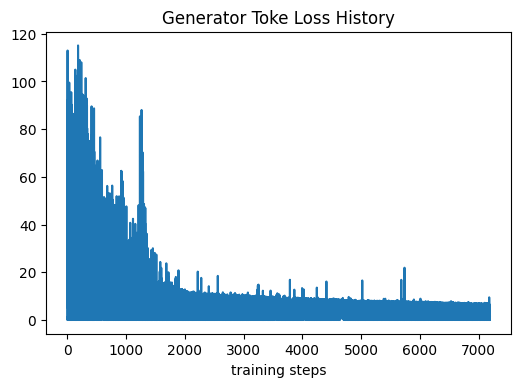

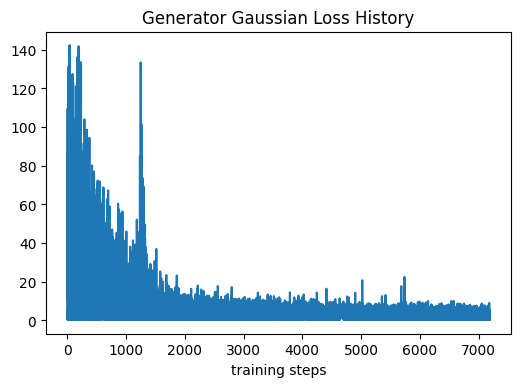

In [68]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

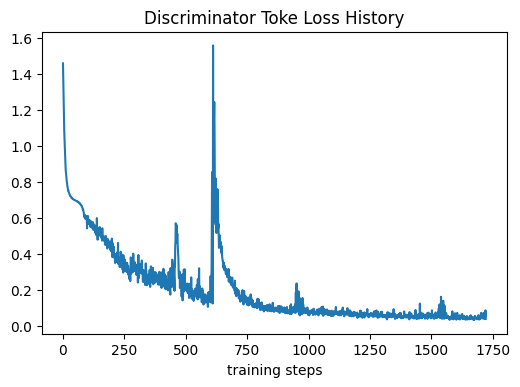

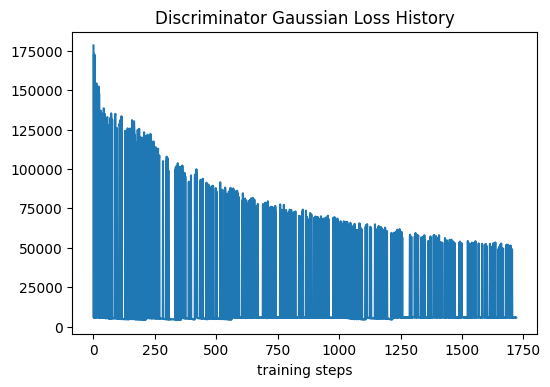

In [69]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

In [70]:
loss_save_dir = './experiment_results/after_22_epochs/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_gaussian_loss_history, f)

## 22 epochs: save G and D

In [71]:
G_save_dir = './experiment_results/after_22_epochs/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [72]:
D_save_dir = './experiment_results/after_22_epochs/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 22 epochs: Generate Sequences

In [73]:
N_gen = 1000 # 
generated_seqs = []

for i in tqdm(range(N_gen)):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout(generator,
                                                                                               T, EVENT_VOCAB_DIM,
                                                                                               verbose=False)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 100 == 0:
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

  0%|          | 1/1000 [00:00<10:07,  1.64it/s]

0
[(1.0, 0), (4.0, 1.0), (1.0, 2.708884620359372), (4.0, 4.5158077769531415), (1.0, 5.5158077769531415), (4.0, 6.5158077769531415), (3.0, 7.5158077769531415), (1.0, 9.410858118685061), (4.0, 11.712438386517508), (2.0, 12.712438386517508), (2.0, 13.712438386517508)]


 10%|█         | 101/1000 [00:30<05:56,  2.52it/s]

100
[(1.0, 0), (1.0, 1.0), (3.0, 2.7680754013529216), (2.0, 4.810165058936113), (1.0, 6.449544817706747), (4.0, 7.584037947684065), (2.0, 9.27054781932502), (1.0, 10.27054781932502), (1.0, 11.27054781932502), (3.0, 12.278029496389765), (3.0, 14.116714879499636)]


 20%|██        | 201/1000 [01:00<05:47,  2.30it/s]

200
[(1.0, 0), (4.0, 1.0), (2.0, 2.0), (2.0, 3.0), (3.0, 4.0), (3.0, 5.0), (1.0, 6.0), (4.0, 7.0), (2.0, 10.361207866374109), (4.0, 11.94619573401599), (3.0, 13.495426168596005)]


 30%|███       | 301/1000 [01:33<03:59,  2.91it/s]

300
[(1.0, 0), (3.0, 1.0), (4.0, 2.0), (3.0, 3.0), (3.0, 4.181708918026257), (1.0, 6.473888628081036), (3.0, 7.8465319040370645), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 40%|████      | 401/1000 [02:01<03:19,  3.00it/s]

400
[(1.0, 0), (1.0, 1.0), (1.0, 2.0), (1.0, 3.591775981302111), (2.0, 4.591775981302111), (4.0, 5.591775981302111), (3.0, 6.88653063416827), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 50%|█████     | 501/1000 [02:29<03:11,  2.61it/s]

500
[(1.0, 0), (3.0, 1.0), (4.0, 2.0), (4.0, 3.0), (2.0, 4.48881599874014), (4.0, 5.48881599874014), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 60%|██████    | 601/1000 [03:00<02:30,  2.66it/s]

600
[(1.0, 0), (2.0, 1.0), (3.0, 2.1476110050978843), (3.0, 3.665953489341528), (2.0, 4.665953489341528), (2.0, 5.730848940036991), (3.0, 6.730848940036991), (2.0, 9.065344219793054), (1.0, 10.065344219793054), (1.0, 12.041688986026166), (4.0, 13.41080410902446)]


 70%|███████   | 701/1000 [03:28<01:20,  3.71it/s]

700
[(1.0, 0), (3.0, 1.0), (4.0, 2.1002596947309677), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 80%|████████  | 801/1000 [04:01<01:00,  3.29it/s]

800
[(1.0, 0), (4.0, 1.3095228017879519), (4.0, 2.309522801787952), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 90%|█████████ | 902/1000 [04:28<00:16,  6.04it/s]

900
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


In [74]:
generated_seqs_save_dir = './experiment_results/after_22_epochs/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

## Continue Training G and D for 2 more epochs, in total 24, change G : D ratio to 16 : 1，and exphasize on minimizing G token loss

In [79]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
# optimizer = SGD(learning_rate=1e-4)

dataset = create_dataset(train_features,
                         train_labels,
                         batch_size=BATCH_SIZE,
                         epochs=8,
                         buffer_size=N_train)

WEIGHT_GAUSSIAN_LOSS = 1e-6
_G_STEPS = 16
_D_STEPS = 1
N_total = train_features[0].shape[0]

In [80]:
_TOTAL_STEPS = int(N_total / BATCH_SIZE * 2)

step = 0

for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
    step += 1
    print('Training Step:', step)

    # train the generator
    for _ in range(_G_STEPS):
        gen_token_loss, gen_gaussian_loss = train_generator(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
        gen_token_loss_history.append(gen_token_loss.numpy())
        gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
    # train the discriminator
    for _ in range(_D_STEPS):
        disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
        disc_token_loss_history.append(disc_token_loss.numpy())
        disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())

0it [00:00, ?it/s]

Training Step: 1


1it [01:05, 65.50s/it]

Training Step: 2


2it [02:09, 65.05s/it]

Training Step: 3


3it [03:05, 62.19s/it]

Training Step: 4


4it [04:08, 62.46s/it]

Training Step: 5


5it [05:11, 62.65s/it]

Training Step: 6


6it [06:15, 63.25s/it]

Training Step: 7


7it [07:18, 63.13s/it]

Training Step: 8


8it [08:24, 63.98s/it]

Training Step: 9


9it [09:33, 65.38s/it]

Training Step: 10


10it [10:42, 66.41s/it]

Training Step: 11


11it [11:43, 64.97s/it]

Training Step: 12


12it [12:47, 64.76s/it]

Training Step: 13


13it [13:48, 63.61s/it]

Training Step: 14


14it [14:52, 63.68s/it]

Training Step: 15


16it [17:06, 65.46s/it]

Training Step: 17


17it [18:09, 64.86s/it]

Training Step: 18


18it [19:07, 62.79s/it]

Training Step: 19


19it [20:18, 65.12s/it]

Training Step: 20


20it [21:23, 65.33s/it]

Training Step: 21


21it [22:31, 66.11s/it]

Training Step: 22


22it [23:37, 65.99s/it]

Training Step: 23


23it [24:49, 67.78s/it]

Training Step: 24


24it [25:53, 66.57s/it]

Training Step: 25


25it [27:03, 67.54s/it]

Training Step: 26


26it [28:09, 67.18s/it]

Training Step: 27


27it [29:13, 66.10s/it]

Training Step: 28


28it [30:19, 66.16s/it]

Training Step: 29


29it [31:27, 66.83s/it]

Training Step: 30


30it [32:33, 66.50s/it]

Training Step: 31


31it [33:38, 66.09s/it]

Training Step: 32


32it [34:46, 66.62s/it]

Training Step: 33


33it [35:57, 67.98s/it]

Training Step: 34


34it [37:01, 66.78s/it]

Training Step: 35


35it [38:04, 65.48s/it]

Training Step: 36


36it [39:12, 66.30s/it]

Training Step: 37


37it [40:11, 64.26s/it]

Training Step: 38


38it [41:12, 63.09s/it]

Training Step: 39


39it [42:17, 63.74s/it]

Training Step: 40


40it [43:27, 65.69s/it]

Training Step: 41


41it [44:33, 65.85s/it]

Training Step: 42


42it [45:38, 65.57s/it]

Training Step: 43


43it [46:42, 65.09s/it]

Training Step: 44


44it [47:44, 64.06s/it]

Training Step: 45


45it [48:47, 63.87s/it]

Training Step: 46


46it [49:47, 62.57s/it]

Training Step: 47


47it [50:56, 64.59s/it]

Training Step: 48


48it [51:56, 63.25s/it]

Training Step: 49


49it [53:05, 64.96s/it]

Training Step: 50


50it [54:10, 64.99s/it]

Training Step: 51


51it [55:08, 62.77s/it]

Training Step: 52


52it [56:11, 62.85s/it]

Training Step: 53


53it [57:15, 63.12s/it]

Training Step: 54


54it [58:21, 64.21s/it]

Training Step: 55


55it [59:23, 63.51s/it]

Training Step: 56


56it [1:00:30, 64.38s/it]

Training Step: 57


57it [1:01:38, 65.59s/it]

Training Step: 58


58it [1:02:47, 66.44s/it]

Training Step: 59


59it [1:03:48, 65.00s/it]

Training Step: 60


60it [1:04:52, 64.66s/it]

Training Step: 61


61it [1:06:01, 65.82s/it]

Training Step: 62


62it [1:07:01, 64.31s/it]

Training Step: 63


63it [1:08:06, 64.49s/it]

Training Step: 64


64it [1:09:05, 62.77s/it]

Training Step: 65


65it [1:10:08, 62.80s/it]

Training Step: 66


66it [1:11:10, 62.60s/it]

Training Step: 67


67it [1:12:16, 63.56s/it]

Training Step: 68


68it [1:13:20, 63.65s/it]

Training Step: 69


69it [1:14:25, 64.08s/it]

Training Step: 70


70it [1:15:35, 65.92s/it]

Training Step: 71


71it [1:16:41, 65.93s/it]

Training Step: 72


72it [1:17:43, 64.73s/it]

Training Step: 73


73it [1:18:45, 64.05s/it]

Training Step: 74


74it [1:19:47, 63.43s/it]

Training Step: 75


75it [1:20:49, 62.97s/it]

Training Step: 76


76it [1:22:03, 66.15s/it]

Training Step: 77


77it [1:23:07, 65.49s/it]

Training Step: 78


78it [1:24:07, 63.96s/it]

Training Step: 79


79it [1:25:14, 64.70s/it]

Training Step: 80


80it [1:26:19, 65.00s/it]

Training Step: 81


81it [1:27:15, 62.21s/it]

Training Step: 82


82it [1:28:22, 63.52s/it]

Training Step: 83


83it [1:29:26, 63.82s/it]

Training Step: 84


84it [1:30:28, 63.11s/it]

Training Step: 85


85it [1:31:35, 64.42s/it]

Training Step: 86


86it [1:32:39, 64.44s/it]

Training Step: 87


87it [1:33:46, 64.96s/it]

Training Step: 88


88it [1:34:53, 65.75s/it]

Training Step: 89


89it [1:35:55, 64.52s/it]

Training Step: 90


90it [1:36:59, 64.33s/it]

Training Step: 91


91it [1:38:05, 65.00s/it]

Training Step: 92


92it [1:39:11, 65.33s/it]

Training Step: 93


93it [1:40:11, 63.49s/it]

Training Step: 94


94it [1:41:18, 64.78s/it]

Training Step: 95


95it [1:42:24, 65.03s/it]

Training Step: 96


96it [1:43:29, 65.06s/it]

Training Step: 97


97it [1:44:31, 64.21s/it]

Training Step: 98


98it [1:45:36, 64.33s/it]

Training Step: 99


99it [1:46:48, 66.56s/it]

Training Step: 100


100it [1:47:57, 67.33s/it]

Training Step: 101


101it [1:48:59, 65.62s/it]

Training Step: 102


102it [1:50:04, 65.62s/it]

Training Step: 103


103it [1:51:03, 63.67s/it]

Training Step: 104


104it [1:52:11, 64.78s/it]

Training Step: 105


105it [1:53:13, 63.99s/it]

Training Step: 106


106it [1:54:21, 65.14s/it]

Training Step: 107


107it [1:55:20, 63.49s/it]

Training Step: 108


108it [1:56:21, 62.69s/it]

Training Step: 109


109it [1:57:29, 64.11s/it]

Training Step: 110


110it [1:58:30, 63.31s/it]

Training Step: 111


111it [1:59:36, 64.09s/it]

Training Step: 112


112it [2:00:38, 63.45s/it]

Training Step: 113


113it [2:01:42, 63.54s/it]

Training Step: 114


114it [2:02:49, 64.81s/it]

Training Step: 115


115it [2:03:55, 65.10s/it]

Training Step: 116


116it [2:04:58, 64.40s/it]

Training Step: 117


117it [2:06:03, 64.48s/it]

Training Step: 118


118it [2:07:09, 64.96s/it]

Training Step: 119


119it [2:08:16, 65.64s/it]

Training Step: 120


120it [2:09:20, 65.33s/it]

Training Step: 121


121it [2:10:33, 67.40s/it]

Training Step: 122


122it [2:11:39, 66.97s/it]

Training Step: 123


123it [2:12:47, 67.41s/it]

Training Step: 124


124it [2:13:48, 65.59s/it]

Training Step: 125


125it [2:14:44, 62.67s/it]

Training Step: 126


126it [2:15:50, 63.46s/it]

Training Step: 127


127it [2:16:51, 62.74s/it]

Training Step: 128


128it [2:17:56, 63.38s/it]

Training Step: 129


129it [2:19:01, 63.91s/it]

Training Step: 130


130it [2:20:08, 64.80s/it]

Training Step: 131


131it [2:21:17, 66.24s/it]

Training Step: 132


132it [2:22:21, 65.39s/it]

Training Step: 133


133it [2:23:31, 66.86s/it]

Training Step: 134


134it [2:24:36, 66.31s/it]

Training Step: 135


135it [2:25:41, 66.00s/it]

Training Step: 136


136it [2:26:46, 65.52s/it]

Training Step: 137


137it [2:27:48, 64.73s/it]

Training Step: 138


138it [2:28:53, 64.73s/it]

Training Step: 139


139it [2:29:53, 63.36s/it]

Training Step: 140


140it [2:30:57, 63.49s/it]

Training Step: 141


141it [2:32:02, 64.02s/it]

Training Step: 142


142it [2:33:06, 63.93s/it]

Training Step: 143


143it [2:34:09, 63.70s/it]

Training Step: 144


144it [2:35:16, 64.60s/it]

Training Step: 145


145it [2:36:14, 62.75s/it]

Training Step: 146


146it [2:37:22, 64.20s/it]

Training Step: 147


147it [2:38:27, 64.42s/it]

Training Step: 148


148it [2:39:33, 64.79s/it]

Training Step: 149


149it [2:40:35, 64.19s/it]

Training Step: 150


150it [2:41:36, 63.03s/it]

Training Step: 151


151it [2:42:39, 63.23s/it]

Training Step: 152


152it [2:43:39, 62.20s/it]

Training Step: 153


153it [2:44:42, 62.25s/it]

Training Step: 154


154it [2:45:50, 64.25s/it]

Training Step: 155


155it [2:46:53, 63.60s/it]

Training Step: 156


156it [2:47:53, 64.57s/it]


## 24 epochs: Loss over training 

Text(0.5, 0, 'training steps')

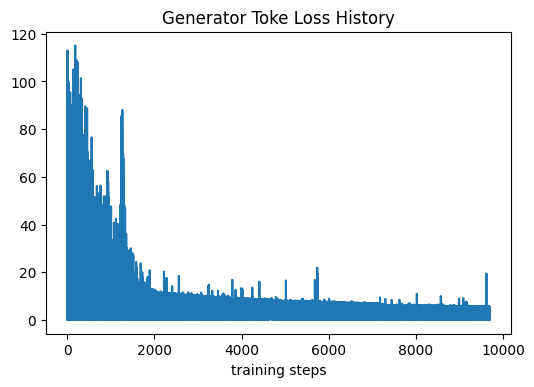

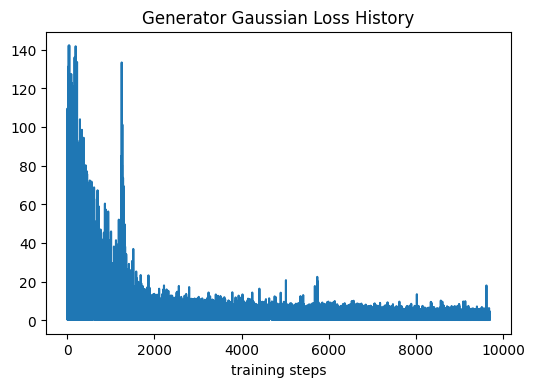

In [81]:
x = range(len(gen_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_token_loss_history)
plt.title('Generator Toke Loss History')
plt.xlabel('training steps')

x = range(len(gen_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, gen_gaussian_loss_history)
plt.title('Generator Gaussian Loss History')
plt.xlabel('training steps')

Text(0.5, 0, 'training steps')

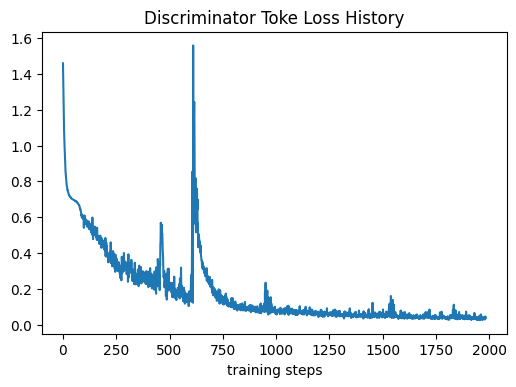

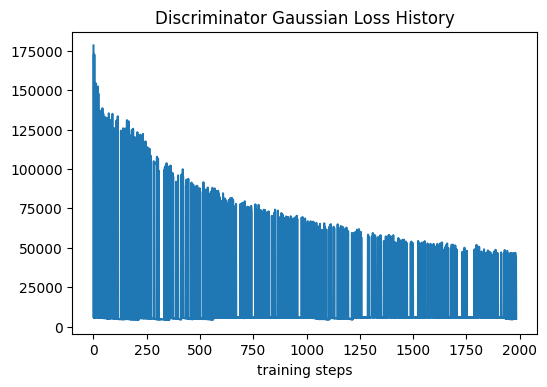

In [82]:
x = range(len(disc_token_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_token_loss_history)
plt.title('Discriminator Toke Loss History')
plt.xlabel('training steps')

x = range(len(disc_gaussian_loss_history))
plt.figure(dpi=100)
plt.plot(x, disc_gaussian_loss_history)
plt.title('Discriminator Gaussian Loss History')
plt.xlabel('training steps')

In [83]:
loss_save_dir = './experiment_results/after_24_epochs/loss'
if not os.path.exists(loss_save_dir):
    os.makedirs(loss_save_dir)

with open(os.path.join(loss_save_dir, 'gen_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'gen_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(gen_gaussian_loss_history, f)
    
with open(os.path.join(loss_save_dir, 'disc_token_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_token_loss_history, f)

with open(os.path.join(loss_save_dir, 'disc_gaussian_loss_history.pickle'), 'wb') as f:
    pickle.dump(disc_gaussian_loss_history, f)

## 24 epochs: save G and D

In [84]:
G_save_dir = './experiment_results/after_24_epochs/gen_weights'
if not os.path.exists(G_save_dir):
    os.makedirs(G_save_dir)
    
G_save_path = os.path.join(G_save_dir, 'gen_model.tf')
generator.save_weights(G_save_path)

In [86]:
D_save_dir = './experiment_results/after_24_epochs/disc_weights'
if not os.path.exists(D_save_dir):
    os.makedirs(D_save_dir)
    
D_save_path = os.path.join(D_save_dir, 'disc_model.tf')
discriminator.save_weights(D_save_path)

## 24 epochs: Generate Sequences

In [87]:
N_gen = 1000 # 
generated_seqs = []

for i in tqdm(range(N_gen)):
    states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout(generator,
                                                                                               T, EVENT_VOCAB_DIM,
                                                                                               verbose=False)
    type_seq = states_et[-1,:,:].squeeze().tolist()
    time_seq = states_ts[-1,:,:].squeeze().tolist()
    recovered_time_seq = recover_timedelta_to_timestamp(time_seq)
    generated_seqs.append(list(zip(type_seq, recovered_time_seq)))
    if i % 100 == 0:
        print(i)
        print(list(zip(type_seq, recovered_time_seq)))

  0%|          | 2/1000 [00:00<07:11,  2.31it/s]

0
[(1.0, 0), (3.0, 1.0), (2.0, 2.243795929387564), (4.0, 4.416305735535579), (3.0, 5.416305735535579), (2.0, 6.416305735535579), (4.0, 7.416305735535579), (1.0, 8.416305735535579), (4.0, 10.000512220041223), (1.0, 12.195878908684989), (4.0, 13.645028429727489)]


 10%|█         | 101/1000 [00:31<04:24,  3.40it/s]

100
[(1.0, 0), (1.0, 1.0), (3.0, 3.3921511639045083), (3.0, 4.392151163904508), (3.0, 5.392151163904508), (2.0, 6.392151163904508), (2.0, 7.392151163904508), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 20%|██        | 203/1000 [01:02<04:08,  3.21it/s]

200
[(1.0, 0), (2.0, 1.0), (3.0, 2.0), (1.0, 4.237145194325555), (2.0, 5.237145194325555), (3.0, 6.562590098616192), (2.0, 7.562590098616192), (1.0, 9.588065995235706), (0.0, 0), (0.0, 0), (0.0, 0)]


 30%|███       | 302/1000 [01:27<02:13,  5.22it/s]

300
[(1.0, 0), (1.0, 1.0), (1.0, 2.0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 40%|████      | 401/1000 [01:57<02:36,  3.82it/s]

400
[(1.0, 0), (1.0, 1.0), (3.0, 3.2629485985117257), (4.0, 4.95568445977448), (4.0, 5.95568445977448), (1.0, 7.973621427184797), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 50%|█████     | 501/1000 [02:25<02:25,  3.42it/s]

500
[(1.0, 0), (4.0, 1.0), (1.0, 2.849925546556439), (4.0, 4.467824298015058), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


 60%|██████    | 602/1000 [02:56<02:03,  3.23it/s]

600
[(1.0, 0), (3.0, 1.0), (4.0, 2.0), (2.0, 3.0), (3.0, 4.0), (1.0, 6.634280613137844), (4.0, 9.456961865762297), (1.0, 10.456961865762297), (0.0, 0), (0.0, 0), (0.0, 0)]


 70%|███████   | 701/1000 [03:28<02:20,  2.13it/s]

700
[(1.0, 0), (4.0, 1.0), (3.0, 2.2156520337620433), (1.0, 3.2156520337620433), (2.0, 4.215652033762043), (4.0, 6.236620326081164), (4.0, 9.173557109962156), (3.0, 10.173557109962156), (3.0, 11.449004447461817), (3.0, 14.054152342590648), (3.0, 15.777883195233958)]


 80%|████████  | 801/1000 [03:59<01:10,  2.82it/s]

800
[(1.0, 0), (3.0, 1.1566504093984842), (3.0, 2.156650409398484), (2.0, 3.9197784969215403), (3.0, 5.052485600974977), (3.0, 6.052485600974977), (2.0, 8.81180126378555), (3.0, 9.81180126378555), (0.0, 0), (0.0, 0), (0.0, 0)]


 90%|█████████ | 900/1000 [04:26<00:20,  4.78it/s]

900
[(1.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0), (0.0, 0)]


100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


In [88]:
generated_seqs_save_dir = './experiment_results/after_24_epochs/generated_seqs'
if not os.path.exists(generated_seqs_save_dir):
    os.makedirs(generated_seqs_save_dir)

with open(os.path.join(generated_seqs_save_dir, 'generated_seqs.pickle'), 'wb') as f:
    pickle.dump(generated_seqs, f)

## Problem with Generator 

1. Token Loss not decrease significantly
2. Gaussian Loss decay is good, but the range of generated time stamps is small

In [102]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras import Sequential
# from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers import Input, LSTM, Embedding, Reshape, Dense
# import tensorflow_probability as tfp
# from tensorflow_probability import distributions as tfd

# from sgtlstm.TimeLSTM import TimeLSTM0, TimeLSTM1, TimeLSTM2, TimeLSTM3

# tf.keras.backend.set_floatx('float64')

# def train_generator_test(generator, discriminator, T, event_vocab_dim, verbose=False, weight_gaussian_loss=1,
#                     optimizer=Adam(lr=0.001)):
#     with tf.GradientTape() as tape:
#         states_et, states_ts, episode_token_probs, gaussian_log = generate_one_sequence_by_rollout_test(generator,
#                                                                                                    T, event_vocab_dim,
#                                                                                                    verbose=verbose)
#         actual_length = episode_token_probs.shape[0]

#         gaussian_log = gaussian_log[0, 0:actual_length, 0]
#         true_prob, _, _ = discriminator((states_et, states_ts))
#         token_loss = -tf.reduce_sum(tf.math.log(episode_token_probs) * true_prob)
#         gaussian_loss = -tf.reduce_sum(gaussian_log * true_prob)
#         generator_loss = token_loss + weight_gaussian_loss * gaussian_loss

#         if verbose:
#             print('generator token loss:{}'.format(token_loss))
#             print('generator gaussian loss:{}'.format(gaussian_loss))
#             print('total generator loss:{}'.format(generator_loss / actual_length))

#     grads = tape.gradient(generator_loss, generator.trainable_variables)
# #     print(grads)
    
#     optimizer.apply_gradients(zip(grads, generator.trainable_variables))

#     return token_loss, gaussian_loss


# def generate_one_sequence_by_rollout_test(generator, T, event_vocab_dim, end_token=0, init_token=1, max_time=1024, verbose=False):
#     # Begin from dummy init state (init_token=1, init_timestamp=0.0)
#     curr_state_et = np.zeros([T])
#     curr_state_et[0] = init_token
#     curr_state_et = curr_state_et.reshape((1, T, 1))

#     curr_state_ts = np.zeros([T])
#     curr_state_ts[0] = 0.0
#     curr_state_ts = curr_state_ts.reshape((1, T, 1))

#     # whole trajectory
#     states_et = (curr_state_et)
#     states_ts = (curr_state_ts)
#     episode_token_probs = tf.constant([1., ], dtype=tf.float64)

#     for step in range(1, T):  # sequence length
#         token_prob, gaussian_log, mask, alpha, mu, sigma = generator([curr_state_et, curr_state_ts])
        
#         print('alpha', alpha)
#         print('mu', mu)
#         print('sigma', sigma)
        
#         # generate one timstamp using [alpha, mu, sigma]
#         gm = tfd.MixtureSameFamily(
#             mixture_distribution=tfd.Categorical(
#                 probs=alpha),
#             components_distribution=tfd.Normal(
#                 loc=mu,
#                 scale=sigma))

#         # sample next event token and time stamp
#         sampled_et = tf.random.categorical(token_prob, num_samples=1)
#         sampled_ts = tf.clip_by_value(gm.sample(), clip_value_min=1, clip_value_max=max_time)  # shape=[BATCH_SIZE,]

#         taken_action_idx = sampled_et.numpy().item()

#         if taken_action_idx == end_token:
#             if verbose:
#                 print('Generation ended early!')
#             break  # episode is over

#         taken_action_prob = token_prob[0][taken_action_idx]
#         taken_action_prob = tf.reshape(taken_action_prob, [1, ])
#         episode_token_probs = tf.concat([episode_token_probs, taken_action_prob], axis=0)

#         new_state_et = np.copy(curr_state_et)
#         new_state_ts = np.copy(curr_state_ts)

#         # TODO: 0 means 1 generation per batch
#         new_state_et[0, step, :] = sampled_et
#         new_state_ts[0, step, :] = sampled_ts

#         if verbose:
#             print('new_state_et', tf.squeeze(new_state_et))

#         states_et = np.concatenate((states_et, new_state_et))
#         states_ts = np.concatenate((states_ts, new_state_ts))

#         curr_state_et = new_state_et
#         curr_state_ts = new_state_ts
#         if verbose:
#             print('Generation done!')

#     if verbose:
#         print('episode length={}'.format(step + 1))
#         print('state_et =', states_et)
#         print('state_ts =', states_ts)
#         print('episode_token_probs =', episode_token_probs)
#         print('gaussian_log =', gaussian_log)

#     return states_et, states_ts, episode_token_probs, gaussian_log

In [104]:
# _TOTAL_STEPS = 1

# step = 0

# for features_batch, _ in tqdm(dataset.take(_TOTAL_STEPS)):
#     step += 1
#     print('Training Step:', step)

#     # train the generator
#     for _ in range(_G_STEPS):
#         gen_token_loss, gen_gaussian_loss = train_generator_test(generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM,  verbose=False, weight_gaussian_loss=WEIGHT_GAUSSIAN_LOSS)
#         gen_token_loss_history.append(gen_token_loss.numpy())
#         gen_gaussian_loss_history.append(gen_gaussian_loss.numpy())        
    
#     # train the discriminator
#     for _ in range(_D_STEPS):
#         disc_token_loss, disc_gaussian_loss = train_discriminator(features_batch, generator, discriminator, T, event_vocab_dim=EVENT_VOCAB_DIM, verbose=False)              
#         disc_token_loss_history.append(disc_token_loss.numpy())
#         disc_gaussian_loss_history.append(disc_gaussian_loss.numpy())